Unweighted Graph Processing: Amazon, DBLP, Youtube are used here from the SNAP Dataset. Only DBLP is being processed here just as an example.

In [ ]:
!gunzip /content/com-dblp.ungraph.txt.gz

gzip: /content/com-dblp.ungraph.txt.gz: No such file or directory


In [ ]:
!gunzip /content/com-dblp.top5000.cmty.txt.gz

gzip: /content/com-dblp.top5000.cmty.txt.gz: No such file or directory


In [ ]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

path = "/content/dblp"
os.makedirs(path, exist_ok=True)
# --- Load the edge list ---
edge_file = "/content/com-dblp.ungraph.txt"
G = nx.read_edgelist(edge_file, nodetype=int)

# --- Precompute degree and clustering coefficient ---
deg_dict = dict(G.degree())
clustering = nx.clustering(G)

# --- Extract edge-level features ---
edge_data = []
for u, v in G.edges():
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))

    common = neighbors_u & neighbors_v
    union = neighbors_u | neighbors_v

    edge_data.append({
        "source": u,
        "target": v,
        "common_neighbors": len(common),
        "jaccard": len(common) / len(union) if union else 0,
        "triangle_count": len([w for w in common if G.has_edge(u, w) and G.has_edge(v, w)]),
        "inverse_degree_sum": 1 / (deg_dict[u] + deg_dict[v]) if (deg_dict[u] + deg_dict[v]) > 0 else 0,
        "avg_clustering": (clustering[u] + clustering[v]) / 2
    })

# --- Create DataFrame ---
edge_df = pd.DataFrame(edge_data)

# --- Apply MinMax scaling ---
features = ['common_neighbors', 'jaccard', 'triangle_count', 'inverse_degree_sum', 'avg_clustering']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(edge_df[features])

# Replace with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# --- Combine scaled features into a weight column (equal weights) ---
edge_df['weight'] = scaled_df.mean(axis=1)

# --- Optional: drop original unscaled features to clean up ---
# edge_df = edge_df[['source', 'target', 'weight_scaled']]

# --- Output ---
print(edge_df[['source', 'target', 'weight']].head())

edge_df[['source', 'target', 'weight']].to_csv('/content/dblp/weighted_edges.csv', index=False)




   source  target    weight
0       0       1  0.028445
1       0       2  0.062695
2       0    4519  0.050837
3       0   23073  0.040500
4       0   33043  0.049157


In [ ]:
#generate csv file containing source, target and weight columns
import os
# Keep only the desired columns
output_df = edge_df[["source", "target", "weight"]]
# Save to CSV
output_df.to_csv("/content/dblp/weighted_edges.csv", index=False)

print("Saved to /content/dblp/weighted_edges.csv")
g = nx.from_pandas_edgelist(output_df)
print(g)

Saved to /content/dblp/weighted_edges.csv
Graph with 317080 nodes and 1049866 edges


In [ ]:
#sample 5000 edges based on the most connected versions
import pandas as pd
import itertools

# --- Parameters ---
EDGE_LIMIT = 5000
community_file = '/content/com-dblp.top5000.cmty.txt'
edge_file = '/content/dblp/weighted_edges.csv'

# --- Load edge list ---
edge_df = pd.read_csv(edge_file)
edge_df['source'] = edge_df['source'].astype(str)
edge_df['target'] = edge_df['target'].astype(str)

# Build a set for quick lookup
edge_tuples = set(zip(edge_df['source'], edge_df['target']))

# --- Load communities ---
communities = []
with open(community_file, 'r') as f:
    for line in f:
        nodes = line.strip().split()
        if nodes:
            communities.append(set(nodes))

# --- Collect internal edges and compute density for each community ---
community_edges = []

for i, comm in enumerate(communities):
    # All node pairs within the community
    possible_edges = set(itertools.permutations(comm, 2))

    # Actual edges that exist in full graph
    internal_edges = [ (u, v) for (u, v) in possible_edges if (u, v) in edge_tuples ]

    n = len(comm)
    m = len(internal_edges)
    if n <= 1:
        density = 0
    else:
        density = m / (n * (n - 1))  # directed graph density

    community_edges.append({
        "index": i,
        "nodes": comm,
        "edges": internal_edges,
        "edge_count": m,
        "density": density
    })

# --- Sort communities by density or edge_count ---
sorted_comms = sorted(community_edges, key=lambda x: (x['density'], x['edge_count']), reverse=True)

# --- Greedily add internal edges until limit ---
final_edges = []
seen = set()

for comm in sorted_comms:
    for (u, v) in comm['edges']:
        if (u, v) not in seen:
            weight = edge_df.loc[(edge_df['source'] == u) & (edge_df['target'] == v), 'weight'].values
            weight = float(weight[0]) if len(weight) > 0 else 1.0
            final_edges.append({
                "source": u,
                "target": v,
                "weight": weight
            })
            seen.add((u, v))
            if len(final_edges) >= EDGE_LIMIT:
                break
    if len(final_edges) >= EDGE_LIMIT:
        break

# --- Save to CSV ---
dense_df = pd.DataFrame(final_edges)
output_path = '/content/dblp/dense_community_graph.csv'
dense_df.to_csv(output_path, index=False)
print(f"✅ Saved dense graph with {len(dense_df)} edges to {output_path}")

KeyboardInterrupt: 

In [ ]:
!pip install netbone

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.3/986.3 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/23

In [ ]:
import pandas as pd
import networkx as nx
import netbone as nb

# Load and clean CSV
df = pd.read_csv('/content/dblp/dense_community_graph.csv')
df.columns = df.columns.str.strip().str.lower()
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# Build graph
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight')
G = nx.relabel_nodes(G, lambda x: str(x))  # optional but may avoid issues
print(G)

DEBUG:jax._src.path:etils.epath found. Using etils.epath for file I/O.


Graph with 551 nodes and 5000 edges


In [ ]:
from netbone.compare import Compare
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Setup as you have it
framework = Compare()
framework.set_network(G)

from netbone.filters import fraction_filter
fractions = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(fraction_filter, fractions)

from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, weight_entropy, transitivity, number_connected_components

gt = nb.global_threshold(G)
hss = nb.high_salience_skeleton(G)
ds = nb.doubly_stochastic(G)
mb = nb.modularity_backbone(G)
framework.add_backbone(gt)
framework.add_backbone(hss)
framework.add_backbone(ds)
framework.add_backbone(mb)

framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
framework.add_property('Weight Entropy', weight_entropy)
framework.add_property('Transitivity', transitivity)
framework.add_property('Number of Connected Components', number_connected_components)

# 1. Get progression results for all properties
results = framework.properties_progression()

metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability', 'Weight Entropy', 'Transitivity', 'Number of Connected Components']

# 2. Normalize each metric DataFrame per backbone column independently
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# --- AHP weighting ---

# Pairwise comparison matrix based on your importance judgments
pairwise_matrix = np.array([
# NF   EF   WF   Den  Deg  Rea  Ent  Tra  CC
 [1,   1,   1,   5,   5,   7,   8,   8,   6],   # Node Fraction
 [1,   1,   1,   5,   5,   6,   7,   7,   6],   # Edge Fraction
 [1,   1,   1,   6,   6,   7,   7,   7,   6],   # Weight Fraction
 [1/5, 1/5, 1/6, 1,   3,   4,   5,   5,   4],   # Density
 [1/5, 1/5, 1/6, 1/3, 1,   3,   4,   4,   3],   # Avg Degree
 [1/7, 1/6, 1/7, 1/4, 1/3, 1,   3,   3,   3],   # Reachability
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1,   2,   2],   # Weight Entropy
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1/2, 1,   2],   # Transitivity
 [1/6, 1/6, 1/6, 1/4, 1/3, 1/3, 1/2, 1/2, 1]    # Connected Components
])
# Calculate principal eigenvector for weights
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_index = np.argmax(eigvals.real)
principal_eigvec = eigvecs[:, max_index].real

# Normalize eigenvector so sum(weights) = 1
weights = principal_eigvec / principal_eigvec.sum()

# Map weights to metrics for clarity
weights_dict = dict(zip(metrics, weights))

print("AHP Weights:")
for m, w in weights_dict.items():
    print(f"{m}: {w:.3f}")

# 3. Aggregate normalized metrics using AHP weights
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

prefer_moderate = ['Edge Fraction', 'Average Degree', 'Density', 'Transitivity', 'Number of Connected Components']

for metric in metrics:
    norm_df = normalized_metrics[metric]

    if metric in prefer_moderate:
        # Apply bell-shaped preference for moderate values
        adjusted_df = 1 - (2 * norm_df - 1) ** 2
        aggregate_scores += adjusted_df * weights_dict[metric]
    else:
        # Keep maximizing for metrics where high is good
        aggregate_scores += norm_df * weights_dict[metric]


# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)



AHP Weights:
Node Fraction: 0.241
Edge Fraction: 0.231
Weight Fraction: 0.252
Density: 0.096
Average Degree: 0.064
Reachability: 0.043
Weight Entropy: 0.027
Transitivity: 0.024
Number of Connected Components: 0.023
                               Best Fraction  Best Aggregate Score
Global Threshold Filter                 0.35              0.651616
High Salience Skeleton Filter           0.35              0.672814
Doubly Stochastic Filter                0.35              0.801187
Modularity Filter                       0.35              0.677281


In [ ]:
#Computing the best optimal score for threshold to yield the highest possible aggregate score
from netbone.compare import Compare
framework = Compare()
framework.set_network(G)
from netbone.filters import threshold_filter, boolean_filter
thresholds = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(threshold_filter, thresholds)
from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, transitivity, weight_entropy, number_connected_components

df =nb.disparity(G)
lans = nb.lans(G)
framework.add_backbone(df)
framework.add_backbone(lans)
framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
framework.add_property('Weight Entropy', weight_entropy)
framework.add_property('Transitivity', transitivity)
framework.add_property('Number of Connected Components', number_connected_components)
# After your setup...

results = framework.properties_progression()

metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability', 'Weight Entropy', 'Transitivity', 'Number of Connected Components']

# 2. Normalize each metric DataFrame per backbone column independently
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# --- AHP weighting ---

# Pairwise comparison matrix based on your importance judgments
pairwise_matrix = np.array([
# NF   EF   WF   Den  Deg  Rea  Ent  Tra  CC
 [1,   1,   1,   5,   5,   7,   8,   8,   6],   # Node Fraction
 [1,   1,   1,   5,   5,   6,   7,   7,   6],   # Edge Fraction
 [1,   1,   1,   6,   6,   7,   7,   7,   6],   # Weight Fraction
 [1/5, 1/5, 1/6, 1,   3,   4,   5,   5,   4],   # Density
 [1/5, 1/5, 1/6, 1/3, 1,   3,   4,   4,   3],   # Avg Degree
 [1/7, 1/6, 1/7, 1/4, 1/3, 1,   3,   3,   3],   # Reachability
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1,   2,   2],   # Weight Entropy
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1/2, 1,   2],   # Transitivity
 [1/6, 1/6, 1/6, 1/4, 1/3, 1/3, 1/2, 1/2, 1]    # Connected Components
])
# Calculate principal eigenvector for weights
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_index = np.argmax(eigvals.real)
principal_eigvec = eigvecs[:, max_index].real

# Normalize eigenvector so sum(weights) = 1
weights = principal_eigvec / principal_eigvec.sum()

# Map weights to metrics for clarity
weights_dict = dict(zip(metrics, weights))

print("AHP Weights:")
for m, w in weights_dict.items():
    print(f"{m}: {w:.3f}")

# 3. Aggregate normalized metrics using AHP weights
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

prefer_moderate = ['Edge Fraction', 'Average Degree', 'Density', 'Transitivity', 'Number of Connected Components']

for metric in metrics:
    norm_df = normalized_metrics[metric]

    if metric in prefer_moderate:
        # Apply bell-shaped preference for moderate values
        adjusted_df = 1 - (2 * norm_df - 1) ** 2
        aggregate_scores += adjusted_df * weights_dict[metric]
    else:
        # Keep maximizing for metrics where high is good
        aggregate_scores += norm_df * weights_dict[metric]

# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)

AHP Weights:
Node Fraction: 0.241
Edge Fraction: 0.231
Weight Fraction: 0.252
Density: 0.096
Average Degree: 0.064
Reachability: 0.043
Weight Entropy: 0.027
Transitivity: 0.024
Number of Connected Components: 0.023
                                                Best Fraction  \
Disparity Filter                                          0.4   
Locally Adaptive Network Sparsification Filter            0.3   

                                                Best Aggregate Score  
Disparity Filter                                            0.563558  
Locally Adaptive Network Sparsification Filter              0.599428  


In [ ]:
#load all of the backbones
gt = nb.global_threshold(G)
global_threshold = fraction_filter(gt, 0.35)
hss = nb.high_salience_skeleton(G)
high_salience_skeleton = fraction_filter(hss, 0.35)
ds = nb.doubly_stochastic(G)
doubly_stochastic = fraction_filter(ds, 0.35)
mb = nb.modularity_backbone(G)
modularity_backbone = fraction_filter(mb, 0.35)
df =nb.disparity(G)
disparity_filter = threshold_filter(df, 0.4)
lans = nb.lans(G)
locally_adaptive = threshold_filter(lans, 0.3)
mst = nb.maximum_spanning_tree(G)
maximum_spanning_tree = boolean_filter(mst)
ud = nb.ultrametric_distance_backbone(G)
ultrametric_distance = boolean_filter(ud)


Global Threshold Filter
High Salience Skeleton Filter
Doubly Stochastic Filter
Modularity Filter
Disparity Filter
Locally Adaptive Network Sparsification Filter
Maximum Spanning Tree
Ultrametric Distance Filter


In [ ]:
import pandas as pd
import os

# Helper function to save graph edges to CSV
def save_graph_edges_to_csv(graph, filepath):
    # Extract edges with data
    edges = list(graph.edges(data=True))

    # Prepare data for DataFrame
    rows = []
    for u, v, data in edges:
        row = {
            'source': u,
            'target': v,
            # Save weight if exists, else default 1
            'weight': data.get('weight', 1)
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Create dirs if not exist
    df.to_csv(filepath, index=False)
    print(f"Saved to {filepath}")

# Example usage with your filters:

save_graph_edges_to_csv(disparity_filter, '/content/dblp/filtered/disparity_filter.csv')
save_graph_edges_to_csv(locally_adaptive, '/content/dblp/filtered/locally_adaptive.csv')
save_graph_edges_to_csv(maximum_spanning_tree, '/content/dblp/filtered/maximum_spanning_tree.csv')
save_graph_edges_to_csv(global_threshold, '/content/dblp/filtered/global_threshold.csv')
save_graph_edges_to_csv(high_salience_skeleton, '/content/dblp/filtered/high_salience_skeleton.csv')
save_graph_edges_to_csv(doubly_stochastic, '/content/dblp/filtered/doubly_stochastic.csv')
save_graph_edges_to_csv(modularity_backbone, '/content/dblp/filtered/modularity_backbone.csv')
save_graph_edges_to_csv(ultrametric_distance, '/content/dblp/filtered/ultrametric_distance_backbone.csv')

Saved to /content/dblp/filtered/disparity_filter.csv
Saved to /content/dblp/filtered/locally_adaptive.csv
Saved to /content/dblp/filtered/maximum_spanning_tree.csv
Saved to /content/dblp/filtered/global_threshold.csv
Saved to /content/dblp/filtered/high_salience_skeleton.csv
Saved to /content/dblp/filtered/doubly_stochastic.csv
Saved to /content/dblp/filtered/modularity_backbone.csv
Saved to /content/dblp/filtered/ultrametric_distance_backbone.csv


In [ ]:
import pandas as pd
import os

# List of backbone names
backbone_names = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone"
]

base_path = "/content/dblp/filtered"  # adjust as needed

all_edges = set()

def load_edges(filepath):
    df = pd.read_csv(filepath)
    for _, row in df.iterrows():
        u, v = int(row['source']), int(row['target'])
        edge = frozenset((u, v))  # undirected edge representation
        all_edges.add(edge)

# Load and collect edges from all backbones
for name in backbone_names:
    path = os.path.join(base_path, f"{name}.csv")
    load_edges(path)

# Convert edge set to DataFrame
combined_edges = pd.DataFrame([list(e) for e in all_edges], columns=["source", "target"])

# Save or inspect
combined_edges.to_csv("/content/dblp/filtered/combined_backbone_edges.csv", index=False)
print(f"Total unique edges combined: {len(combined_edges)}")


Total unique edges combined: 4988


In [ ]:
import pandas as pd
import os
import networkx as nx
from collections import defaultdict
import numpy as np

# Define the base path where backbone CSVs are stored
base_path = "/content/dblp/filtered"

# Define categories and weights for ensemble learning
categories = {
    "statistical": ["disparity_filter", "locally_adaptive"],
    "structural": ["maximum_spanning_tree", "ultrametric_distance_backbone"],
    "global": ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone"]
}

# Assign weights equally across categories and within each category
category_weight = 1 / len(categories)
backbone_weights = {}
for cat, methods in categories.items():
    method_weight = category_weight / len(methods)
    for method in methods:
        backbone_weights[method] = method_weight

# Initialize dictionaries to store cumulative scores and agreement counts
edge_weighted_scores = defaultdict(float)
edge_agreement_counts = defaultdict(int)

# Aggregate edge scores and counts across all backbones
for name in backbone_weights:
    df = pd.read_csv(os.path.join(base_path, f"{name}.csv"))
    for _, row in df.iterrows():
        u, v = int(row['source']), int(row['target'])
        edge = frozenset((u, v))  # undirected
        edge_weighted_scores[edge] += backbone_weights[name]
        edge_agreement_counts[edge] += 1

# Compute final scores: method-weighted score * agreement count
edge_final_scores = {
    edge: edge_weighted_scores[edge] * edge_agreement_counts[edge]
    for edge in edge_weighted_scores
}

# Function to save graph to CSV
def save_graph_to_csv(graph, filepath):
    edges = list(graph.edges(data=True))
    rows = [{
        'source': u,
        'target': v,
        'weight': data.get('weight', 1)
    } for u, v, data in edges]
    df = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    df.to_csv(filepath, index=False)
    print(f"✅ Saved: {filepath}")

# Vary percentile thresholds
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
graphs_by_percentile = {}

all_scores = np.array(list(edge_final_scores.values()))

for p in percentiles:
    threshold = np.percentile(all_scores, p)
    p_1 = int(p/10)
    G = nx.Graph()
    for edge, score in edge_final_scores.items():
        if score >= threshold:
            u, v = tuple(edge)
            G.add_edge(u, v, weight=score)
    graphs_by_percentile[p] = G
    filename = os.path.join(base_path, f"combined_backbone_agreement_{p_1}.csv")
    save_graph_to_csv(G, filename)





✅ Saved: /content/dblp/filtered/combined_backbone_agreement_1.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_2.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_3.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_4.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_5.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_6.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_7.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_8.csv
✅ Saved: /content/dblp/filtered/combined_backbone_agreement_9.csv


Saved communities to community_outputs/girvan_newman_global_threshold.txt


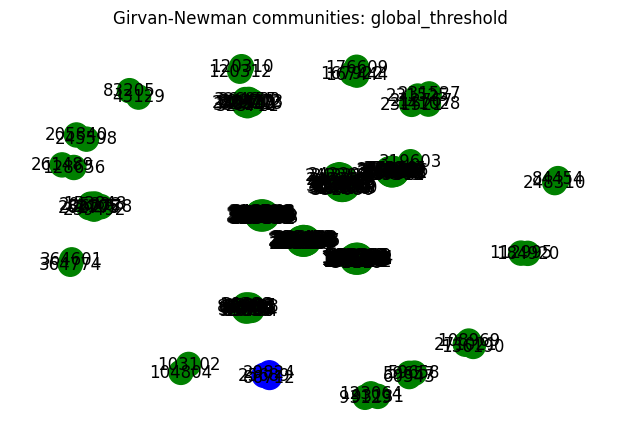

Saved communities to community_outputs/girvan_newman_high_salience_skeleton.txt


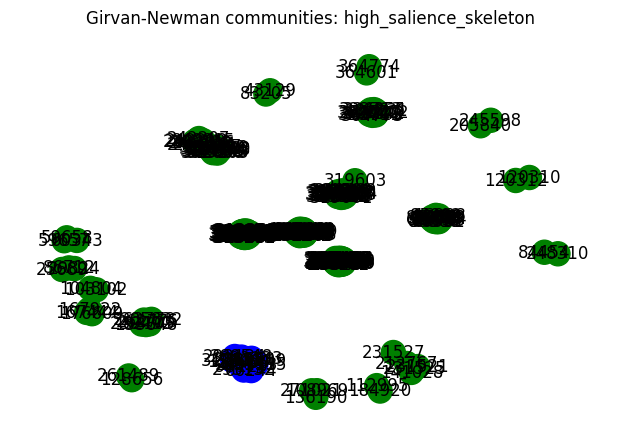

Saved communities to community_outputs/girvan_newman_doubly_stochastic.txt


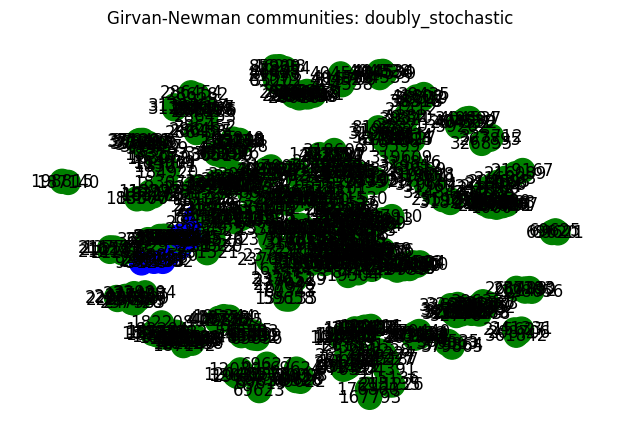

Saved communities to community_outputs/girvan_newman_modularity_backbone.txt


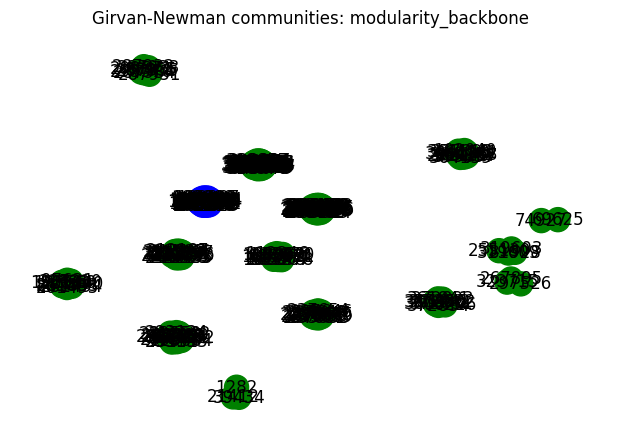

Saved communities to community_outputs/girvan_newman_disparity_filter.txt


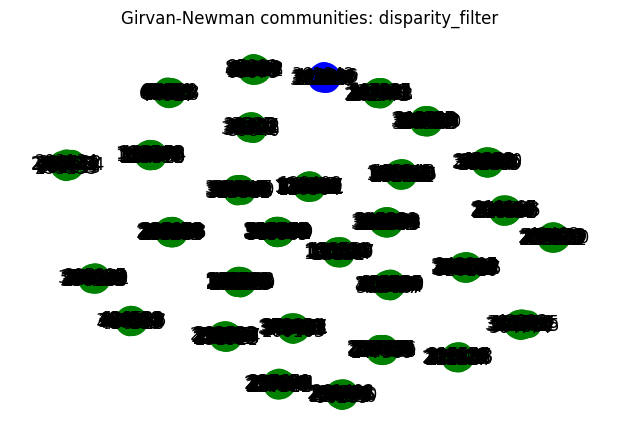

Saved communities to community_outputs/girvan_newman_locally_adaptive.txt


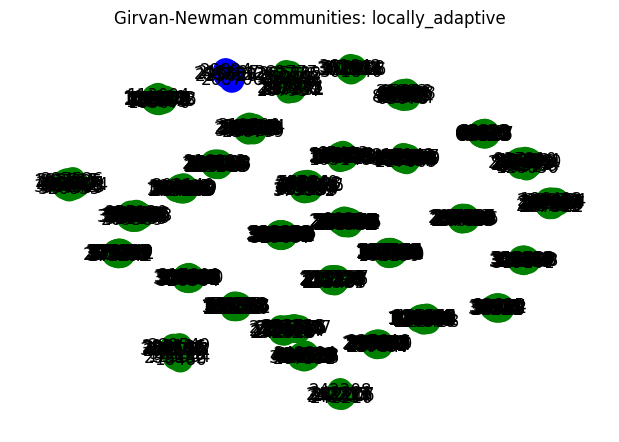

Saved communities to community_outputs/girvan_newman_maximum_spanning_tree.txt


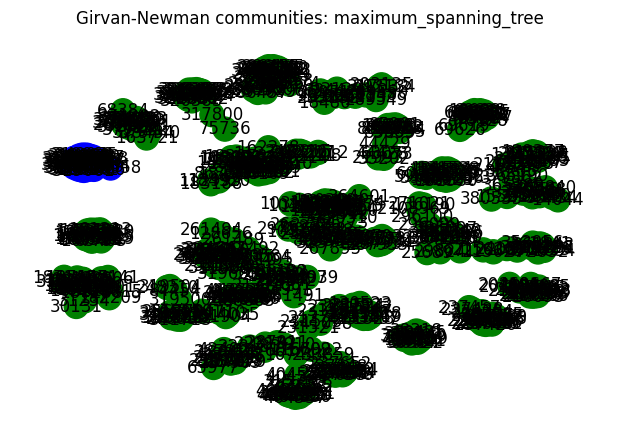

Saved communities to community_outputs/girvan_newman_ultrametric_distance_backbone.txt


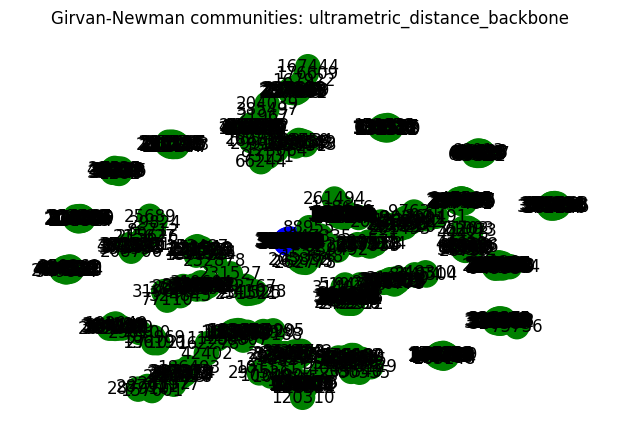

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_1.txt


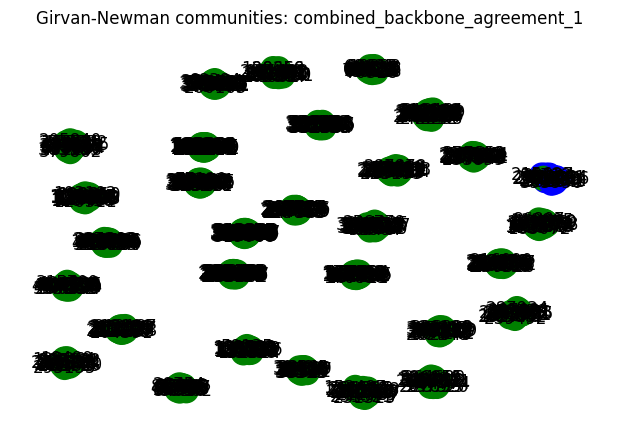

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_2.txt


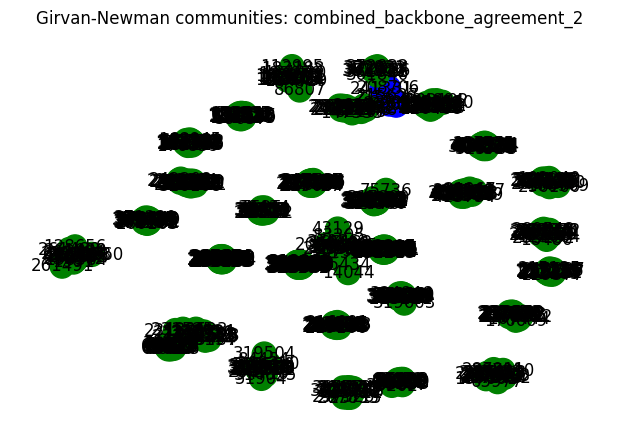

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_3.txt


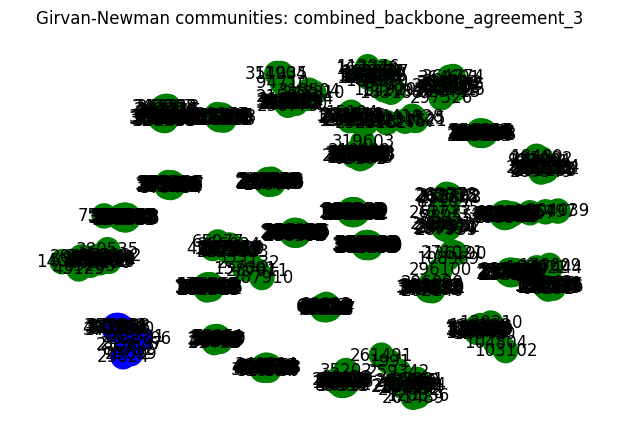

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_4.txt


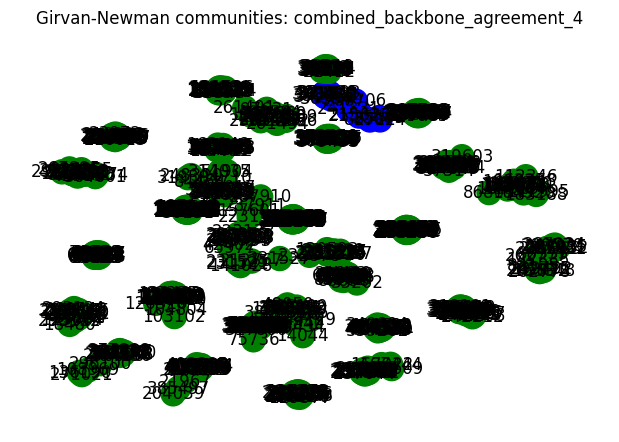

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_5.txt


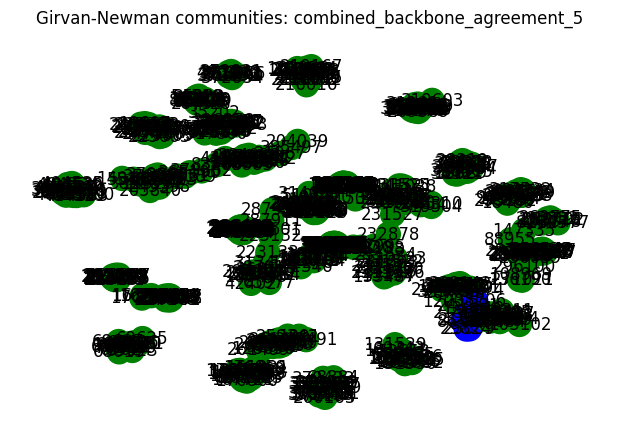

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_6.txt


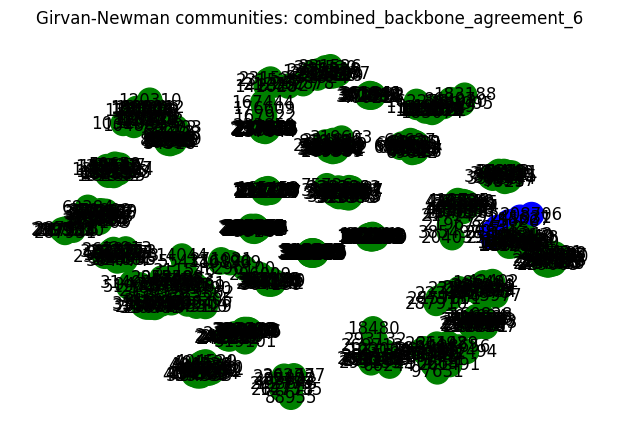

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_7.txt


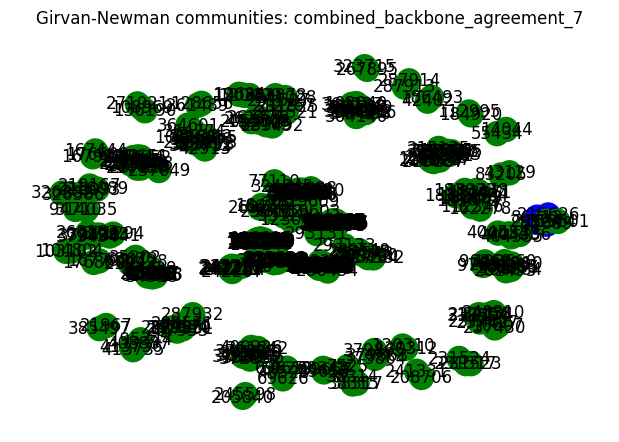

Saved communities to community_outputs/girvan_newman_combined_backbone_agreement_8.txt


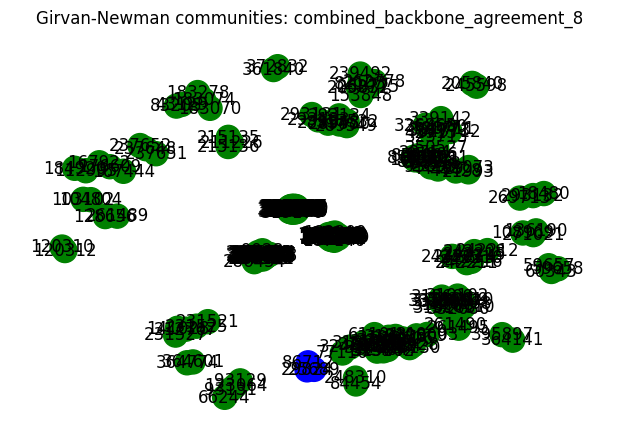

Saved communities to community_outputs/girvan_newman_dense_community_graph.txt


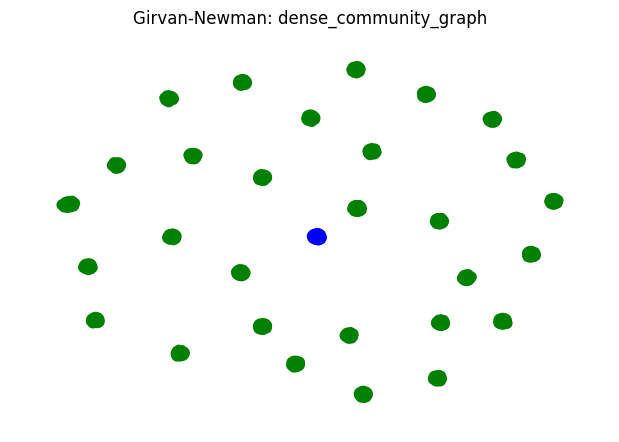


Community Summary Table:
                     Backbone  Communities  Nodes  Edges
             global_threshold           23    195   1750
       high_salience_skeleton           23    206   1750
            doubly_stochastic           49    533    916
          modularity_backbone           16    191   1727
             disparity_filter           31    551   4984
             locally_adaptive           33    551   4138
        maximum_spanning_tree           31    551    521
ultrametric_distance_backbone           31    551   3624
combined_backbone_agreement_1           31    551   4542
combined_backbone_agreement_2           31    551   4013
combined_backbone_agreement_3           31    551   3762
combined_backbone_agreement_4           31    551   3762
combined_backbone_agreement_5           32    551   2543
combined_backbone_agreement_6           33    551   2442
combined_backbone_agreement_7           49    345   1637
combined_backbone_agreement_8           32    221   1303
     

In [ ]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd

os.makedirs("community_outputs", exist_ok=True)

summary_data = []

#generate backbones for the dblp graphs

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone", "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8"]:
    bb = f"/content/dblp/filtered/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume already filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(com) for com in first_split]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"community_outputs/girvan_newman_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Girvan-Newman communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/dblp/dense_community_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "community_outputs/girvan_newman_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("community_outputs/girvan_newman.csv", index=False)



Saved communities to community_outputs/louvain_global_threshold.txt


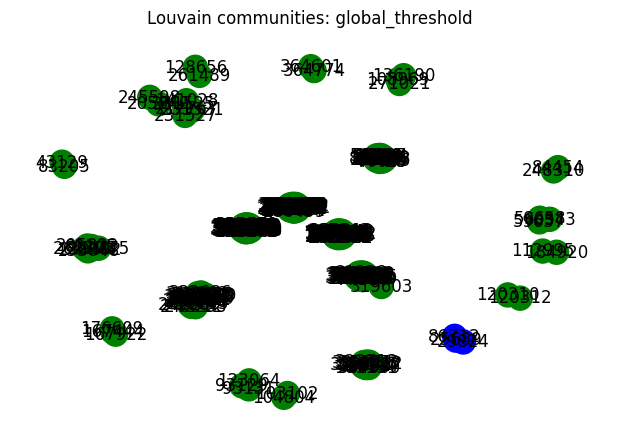

Saved communities to community_outputs/louvain_high_salience_skeleton.txt


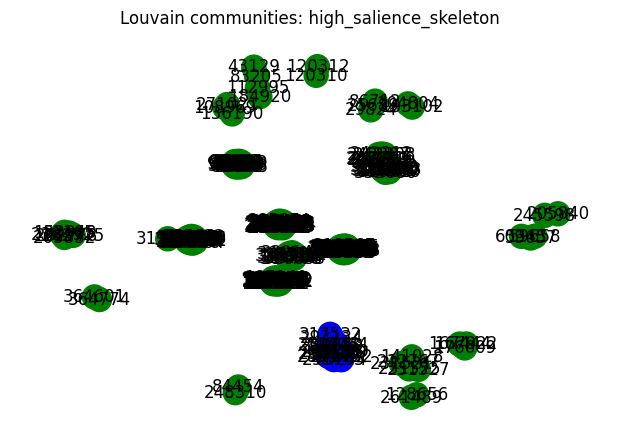

Saved communities to community_outputs/louvain_doubly_stochastic.txt


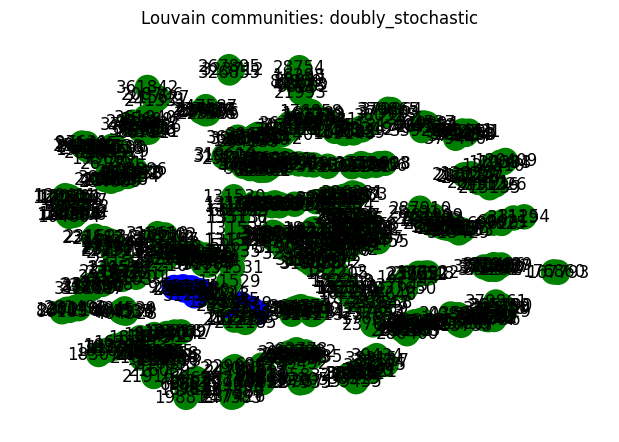

Saved communities to community_outputs/louvain_modularity_backbone.txt


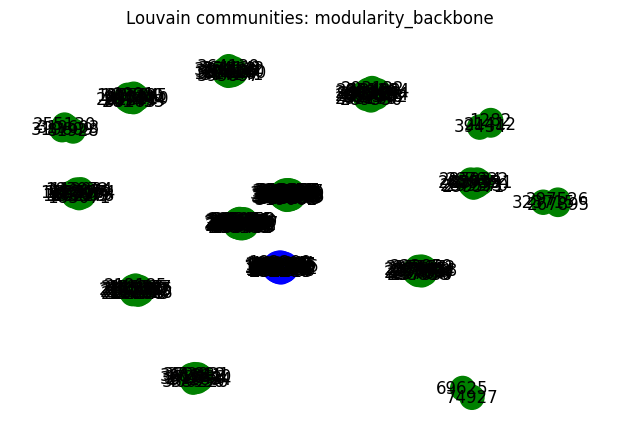

Saved communities to community_outputs/louvain_disparity_filter.txt


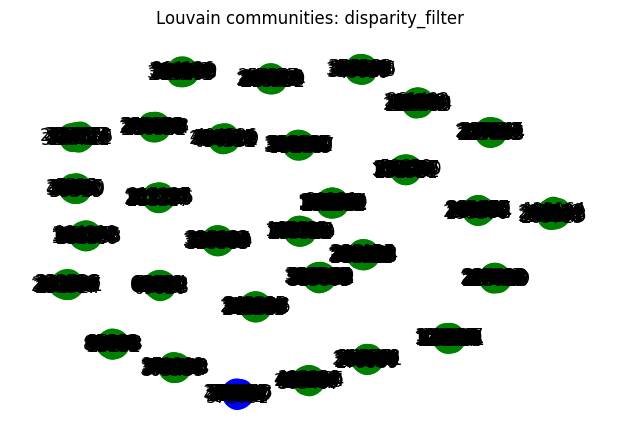

Saved communities to community_outputs/louvain_locally_adaptive.txt


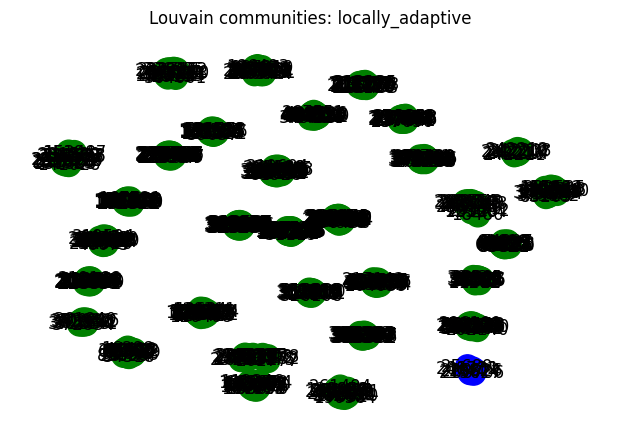

Saved communities to community_outputs/louvain_maximum_spanning_tree.txt


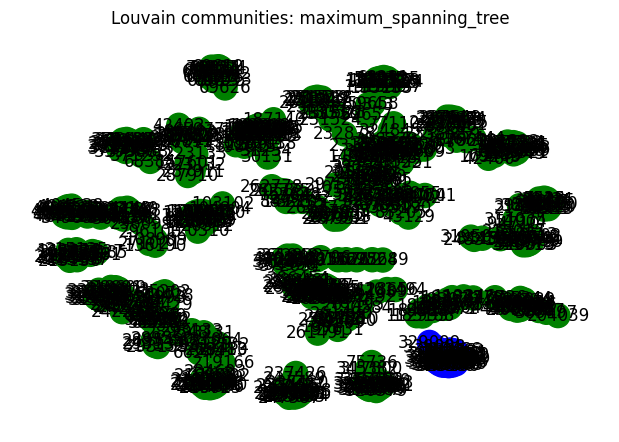

Saved communities to community_outputs/louvain_ultrametric_distance_backbone.txt


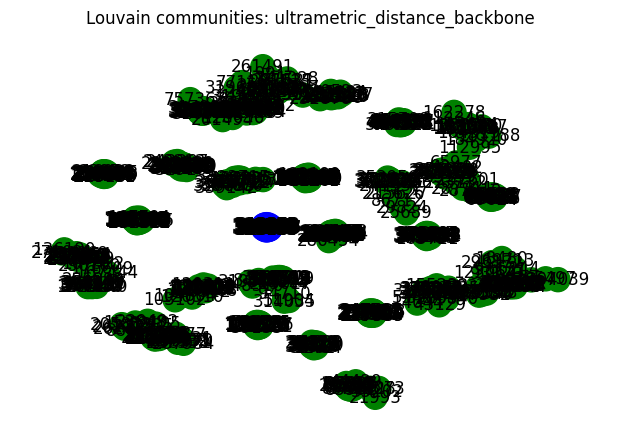

Saved communities to community_outputs/louvain_combined_backbone_agreement_1.txt


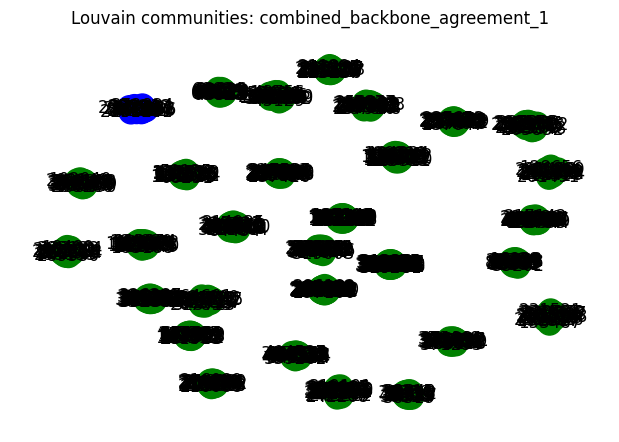

Saved communities to community_outputs/louvain_combined_backbone_agreement_2.txt


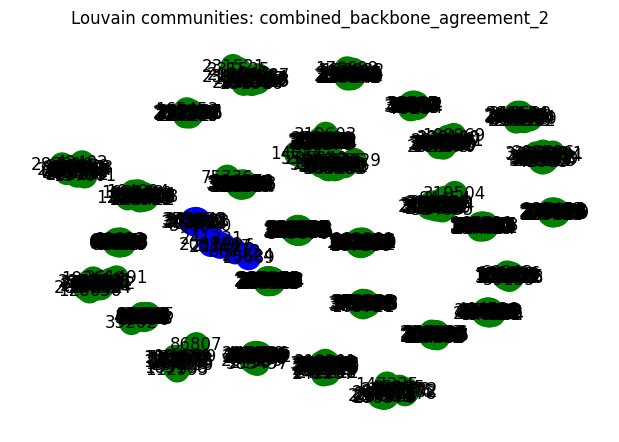

Saved communities to community_outputs/louvain_combined_backbone_agreement_3.txt


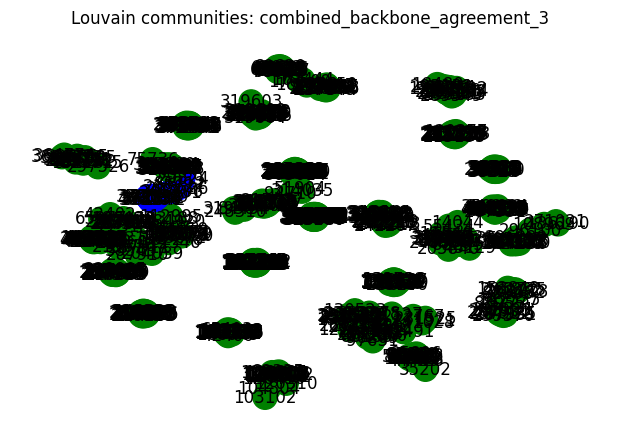

Saved communities to community_outputs/louvain_combined_backbone_agreement_4.txt


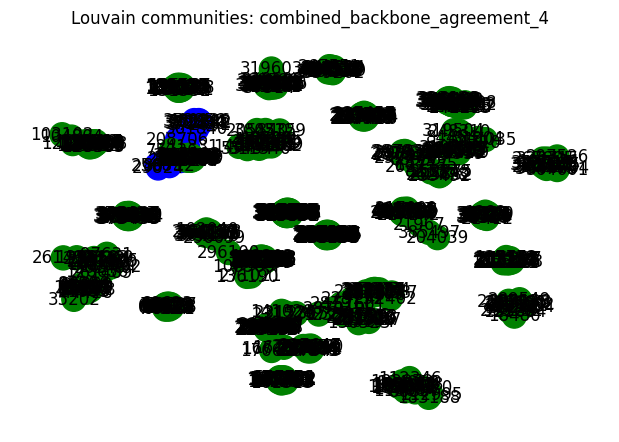

Saved communities to community_outputs/louvain_combined_backbone_agreement_5.txt


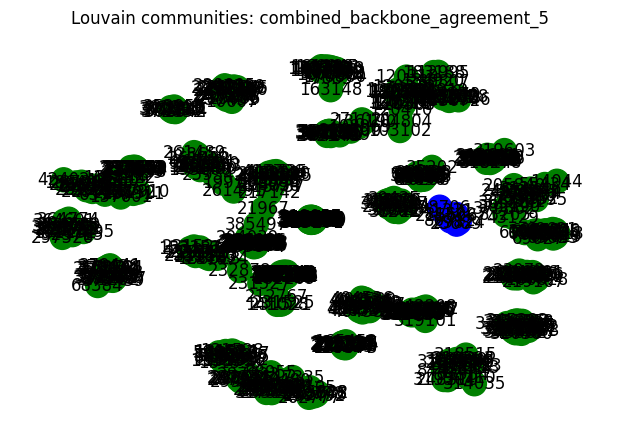

Saved communities to community_outputs/louvain_combined_backbone_agreement_6.txt


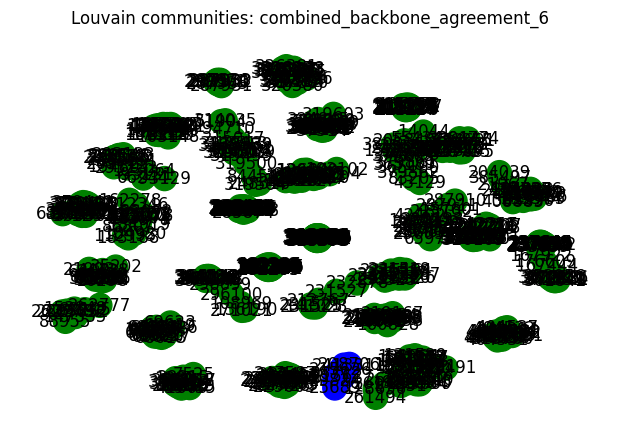

Saved communities to community_outputs/louvain_combined_backbone_agreement_7.txt


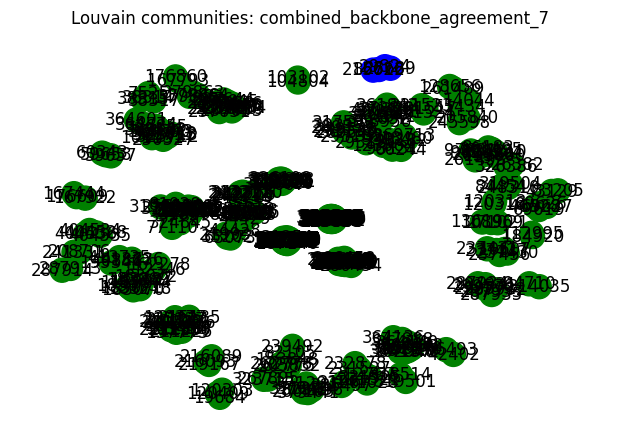

Saved communities to community_outputs/louvain_combined_backbone_agreement_8.txt


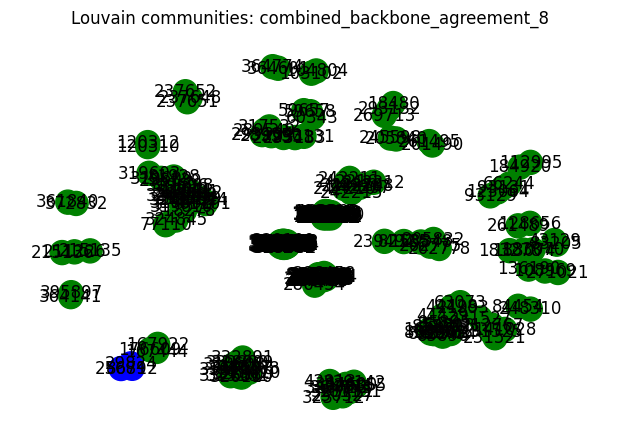

Saved communities to community_outputs/louvain_dense_community_graph.txt


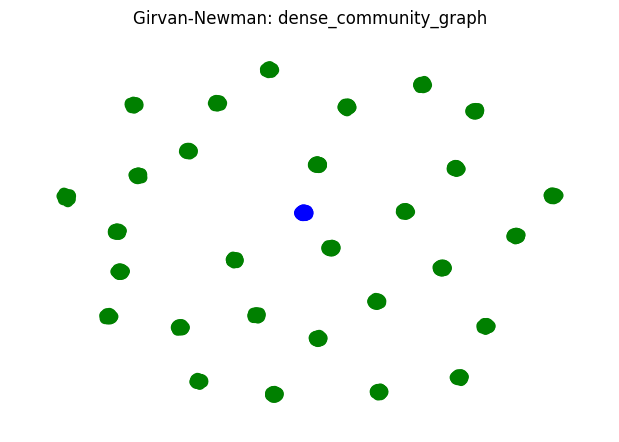


Community Summary Table:
                     Backbone  Communities  Nodes  Edges
             global_threshold           22    195   1750
       high_salience_skeleton           22    206   1750
            doubly_stochastic           49    533    916
          modularity_backbone           15    191   1727
             disparity_filter           30    551   4984
             locally_adaptive           32    551   4138
        maximum_spanning_tree           30    551    521
ultrametric_distance_backbone           30    551   3624
combined_backbone_agreement_1           30    551   4542
combined_backbone_agreement_2           30    551   4013
combined_backbone_agreement_3           30    551   3762
combined_backbone_agreement_4           30    551   3762
combined_backbone_agreement_5           31    551   2543
combined_backbone_agreement_6           32    551   2442
combined_backbone_agreement_7           49    345   1637
combined_backbone_agreement_8           31    221   1303
     

In [ ]:
from networkx.algorithms.community import louvain_communities

summary_data = []

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",  "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8"]:
    bb = f"/content/dblp/filtered/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = louvain_communities(G, seed=42)
        node_groups = [list(c) for c in communities]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"community_outputs/louvain_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Louvain communities: {name}")
    plt.tight_layout()
    plt.show()


csv_path = "/content/dblp/dense_community_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = louvain_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "community_outputs/louvain_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })


# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("community_outputs/louvain.csv", index=False)




Saved communities to community_outputs/lpa_global_threshold.txt


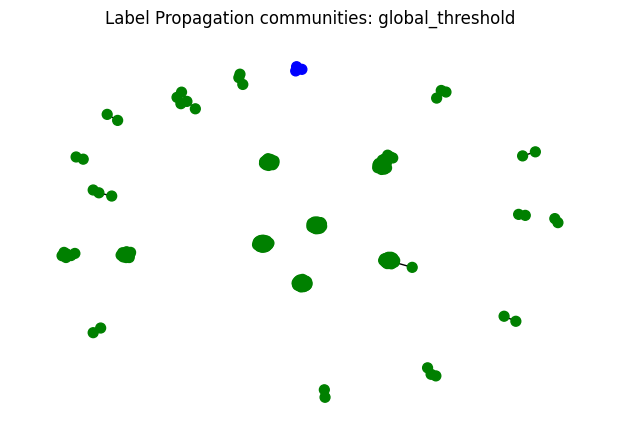

Saved communities to community_outputs/lpa_high_salience_skeleton.txt


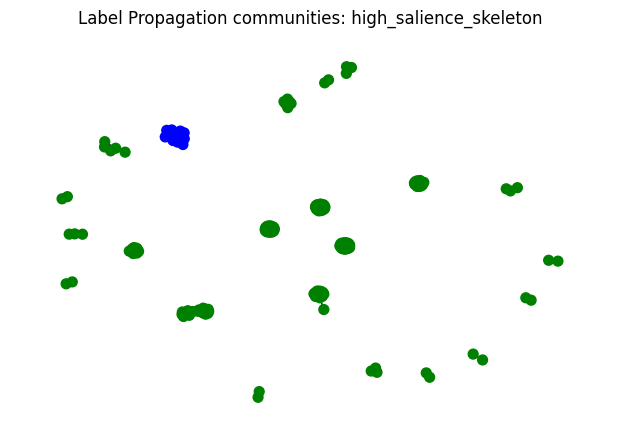

Saved communities to community_outputs/lpa_doubly_stochastic.txt


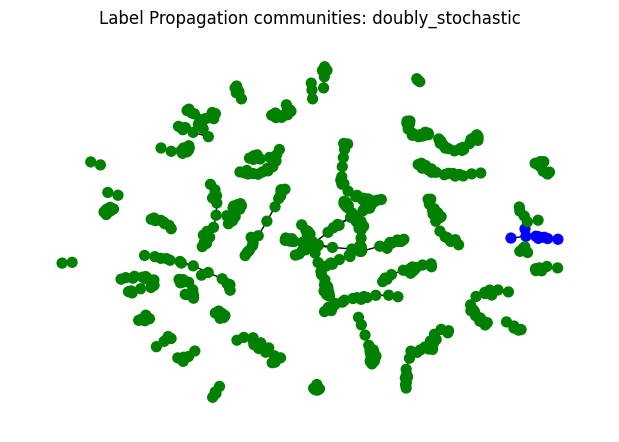

Saved communities to community_outputs/lpa_modularity_backbone.txt


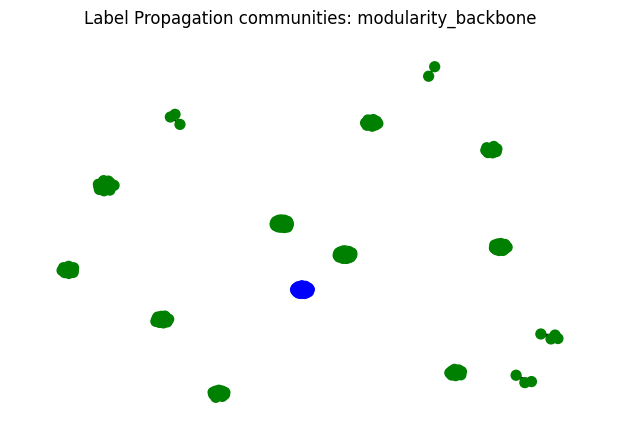

Saved communities to community_outputs/lpa_disparity_filter.txt


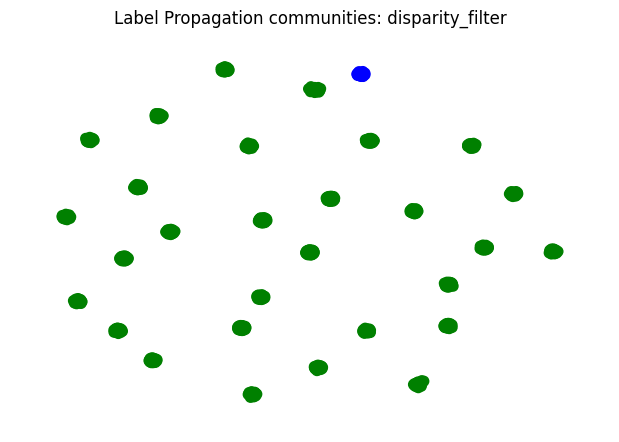

Saved communities to community_outputs/lpa_locally_adaptive.txt


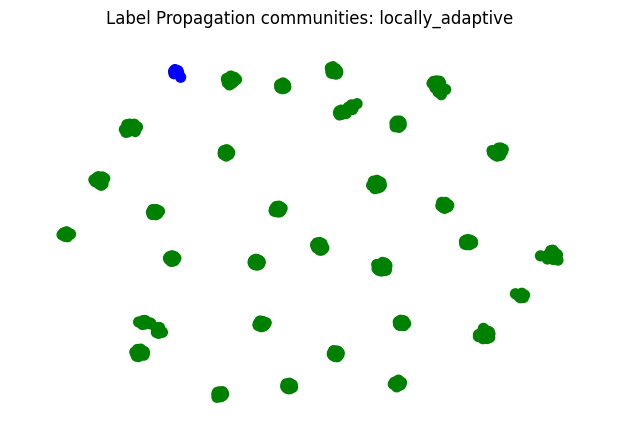

Saved communities to community_outputs/lpa_maximum_spanning_tree.txt


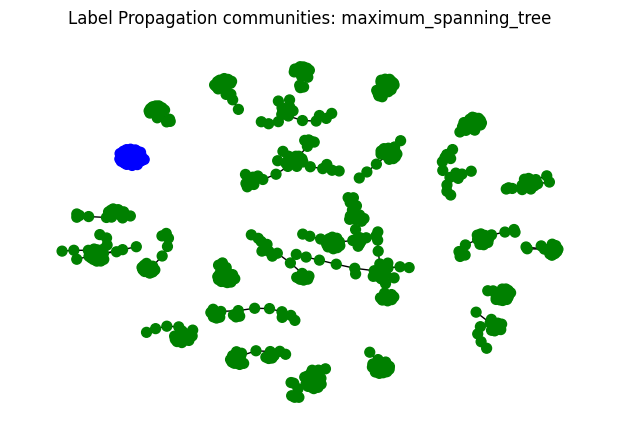

Saved communities to community_outputs/lpa_ultrametric_distance_backbone.txt


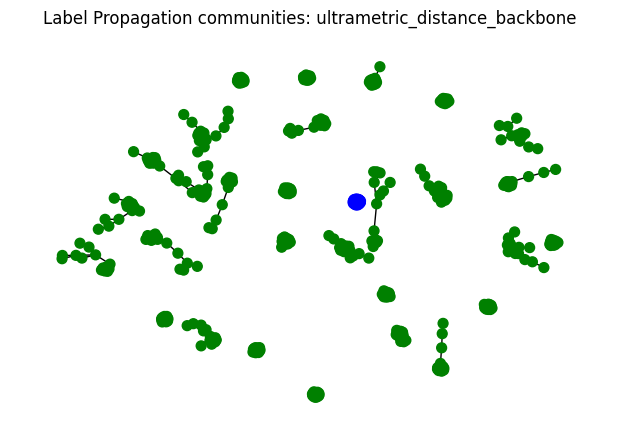

Saved communities to community_outputs/lpa_combined_backbone_agreement_1.txt


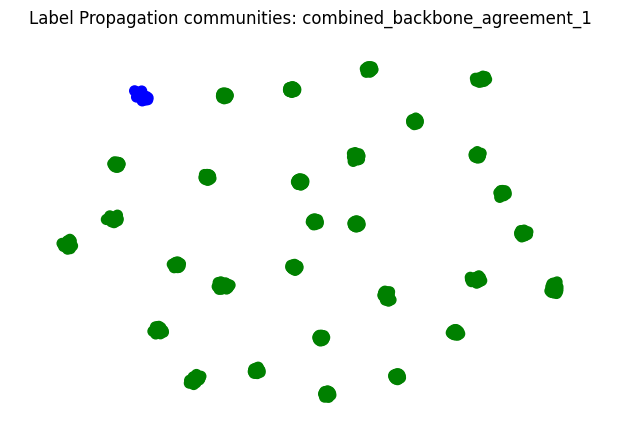

Saved communities to community_outputs/lpa_combined_backbone_agreement_2.txt


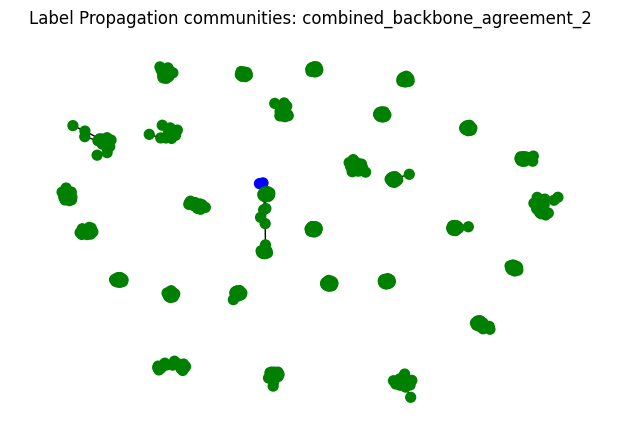

Saved communities to community_outputs/lpa_combined_backbone_agreement_3.txt


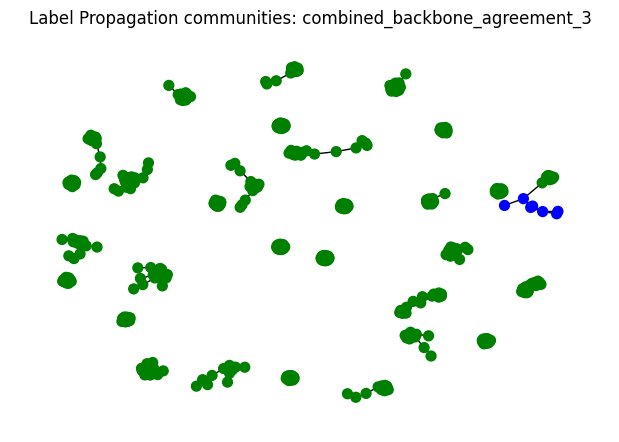

Saved communities to community_outputs/lpa_combined_backbone_agreement_4.txt


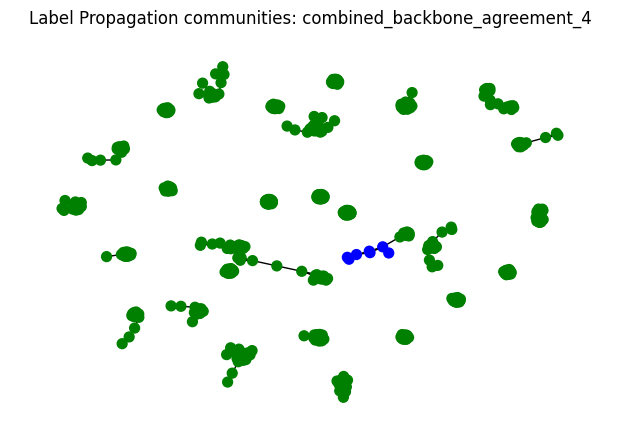

Saved communities to community_outputs/lpa_combined_backbone_agreement_5.txt


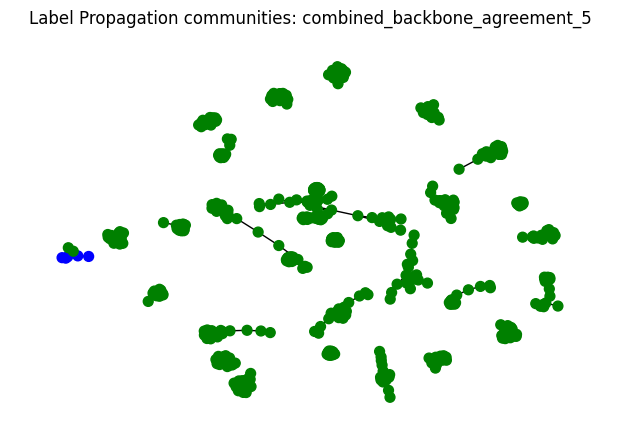

Saved communities to community_outputs/lpa_combined_backbone_agreement_6.txt


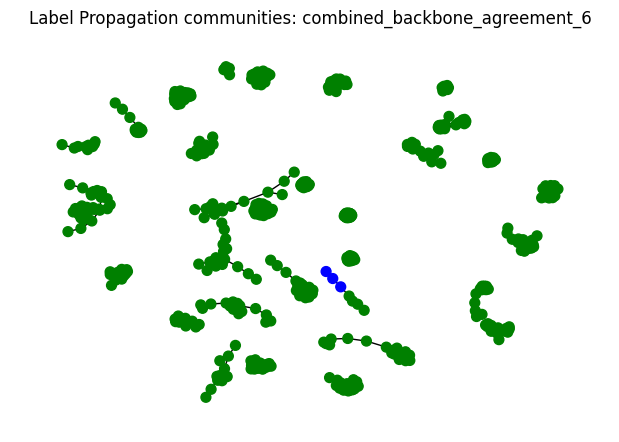

Saved communities to community_outputs/lpa_combined_backbone_agreement_7.txt


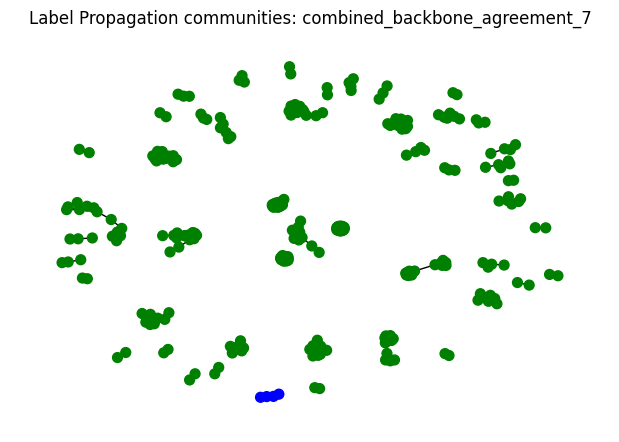

Saved communities to community_outputs/lpa_combined_backbone_agreement_8.txt


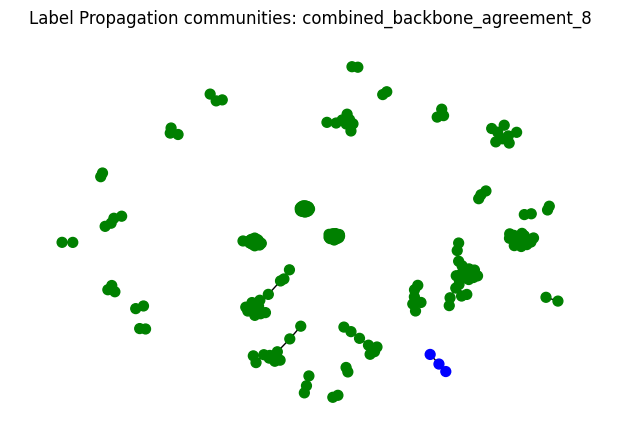

Saved communities to community_outputs/lpa_dense_community_graph.txt


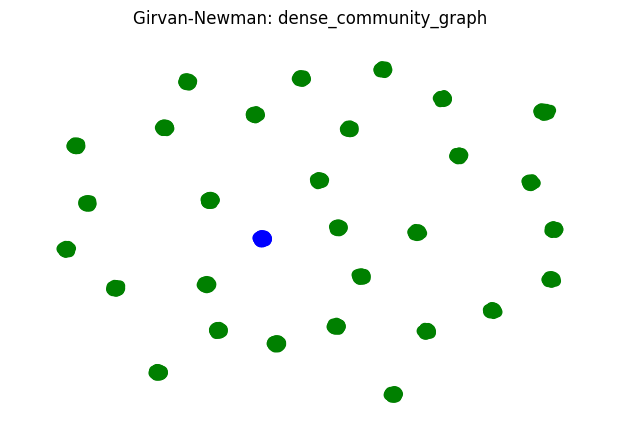


Community Summary Table:
                     Backbone  Communities  Nodes  Edges
             global_threshold           22    195   1750
       high_salience_skeleton           23    206   1750
            doubly_stochastic           97    533    916
          modularity_backbone           15    191   1727
             disparity_filter           30    551   4984
             locally_adaptive           33    551   4138
        maximum_spanning_tree           85    551    521
ultrametric_distance_backbone           54    551   3624
combined_backbone_agreement_1           30    551   4542
combined_backbone_agreement_2           34    551   4013
combined_backbone_agreement_3           46    551   3762
combined_backbone_agreement_4           46    551   3762
combined_backbone_agreement_5           54    551   2543
combined_backbone_agreement_6           58    551   2442
combined_backbone_agreement_7           59    345   1637
combined_backbone_agreement_8           38    221   1303
     

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from networkx.algorithms.community import label_propagation_communities

summary_data = []
os.makedirs("community_outputs", exist_ok=True)

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",  "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8"]:
    file_path = f"/content/dblp/filtered/{name}.csv"

    try:
        df = pd.read_csv(file_path)
        G = nx.from_pandas_edgelist(df)
    except Exception as e:
        print(f"Skipping {name} due to file/read error: {e}")
        continue

    if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        # Run Label Propagation
        communities = label_propagation_communities(G)
        node_groups = [list(c) for c in communities]

    except Exception as e:
        print(f"Skipping {name} due to LPA error: {e}")
        continue

    # Save communities
    out_path = f"community_outputs/lpa_{name}.txt"
    with open(out_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {out_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot first two communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
    plt.title(f"Label Propagation communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/dblp/dense_community_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = label_propagation_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "community_outputs/lpa_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })



# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))
df_summary.to_csv("community_outputs/lpa.csv", index=False)


Scores saved to /content/dblp/filtered/girvan_newman_global_threshold_scores.csv
Overall weighted score for girvan_newman_global_threshold: 0.6338345379223896

Scores saved to /content/dblp/filtered/louvain_global_threshold_scores.csv
Overall weighted score for louvain_global_threshold: 0.6325040769155927

Scores saved to /content/dblp/filtered/lpa_global_threshold_scores.csv
Overall weighted score for lpa_global_threshold: 0.6325040769155927

Scores saved to /content/dblp/filtered/girvan_newman_high_salience_skeleton_scores.csv
Overall weighted score for girvan_newman_high_salience_skeleton: 0.6358511653934676

Scores saved to /content/dblp/filtered/louvain_high_salience_skeleton_scores.csv
Overall weighted score for louvain_high_salience_skeleton: 0.627631857981681

Scores saved to /content/dblp/filtered/lpa_high_salience_skeleton_scores.csv
Overall weighted score for lpa_high_salience_skeleton: 0.6038540269996806

Scores saved to /content/dblp/filtered/girvan_newman_doubly_stochasti

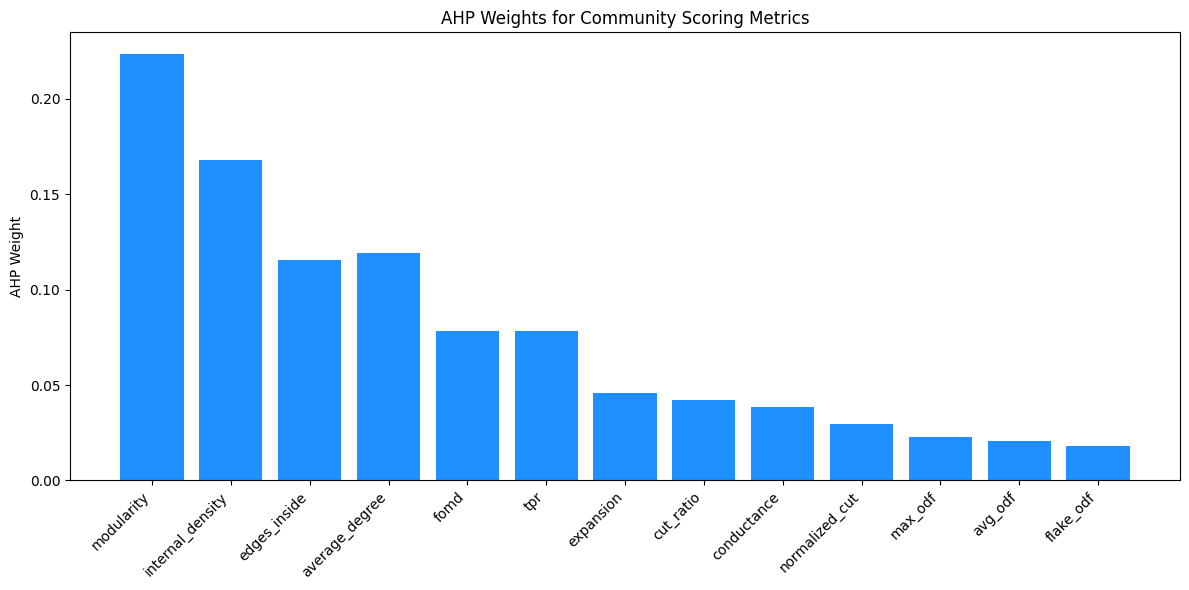

        Algorithm                       Backbone     Score
0   girvan_newman               global_threshold  0.633835
1   girvan_newman         high_salience_skeleton  0.635851
2   girvan_newman              doubly_stochastic  0.610844
3   girvan_newman            modularity_backbone  0.639948
4   girvan_newman               disparity_filter  0.655035
5   girvan_newman               locally_adaptive  0.527064
6   girvan_newman          maximum_spanning_tree  0.539328
7   girvan_newman  ultrametric_distance_backbone  0.556207
8   girvan_newman  combined_backbone_agreement_1  0.654758
9   girvan_newman  combined_backbone_agreement_2  0.545305
10  girvan_newman  combined_backbone_agreement_3  0.556207
11  girvan_newman  combined_backbone_agreement_4  0.556207
12  girvan_newman  combined_backbone_agreement_5  0.543437
13  girvan_newman  combined_backbone_agreement_6  0.536260
14  girvan_newman  combined_backbone_agreement_7  0.522231
15  girvan_newman  combined_backbone_agreement_8  0.5425

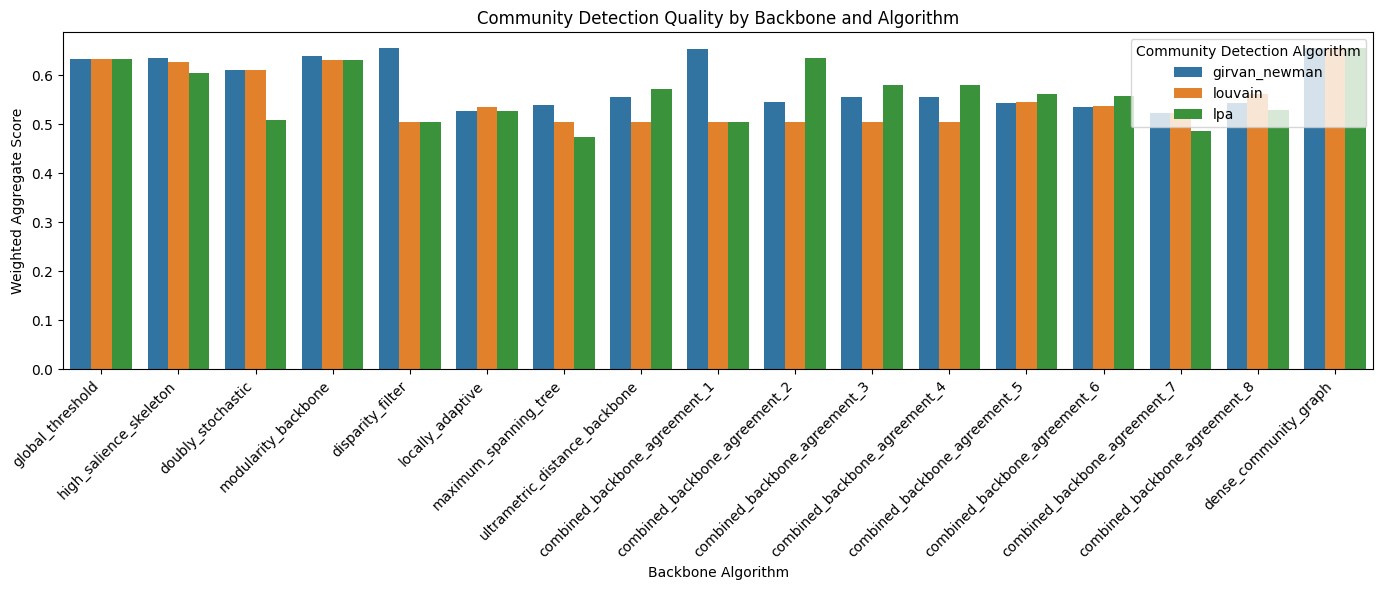

In [ ]:
##calculating the structural score
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import os

from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  # For visualization

# ------------------------------
# Helper functions for each metric -- goodness metrics and community scoring functions
# ------------------------------

def internal_density(G, S):
    subG = G.subgraph(S)
    n = len(S)
    m = subG.number_of_edges()
    return (2 * m) / (n * (n - 1)) if n > 1 else 0

def edges_inside(G, S):
    return G.subgraph(S).number_of_edges()

def average_degree(G, S):
    m = G.subgraph(S).number_of_edges()
    n = len(S)
    return (2 * m) / n if n > 0 else 0

def fraction_over_median_degree(G, S):
    degrees = [len([v for v in G.neighbors(u) if v in S]) for u in S]
    median = np.median([G.degree(u) for u in S])
    count = sum(d > median for d in degrees)
    return count / len(S) if S else 0

def triangle_participation_ratio(G, S):
    count = 0
    for u in S:
        neighbors = set(G.neighbors(u)).intersection(S)
        found_triangle = False
        for v, w in combinations(neighbors, 2):
            if G.has_edge(v, w):
                found_triangle = True
                break
        if found_triangle:
            count += 1
    return count / len(S) if S else 0

def expansion(G, S):
    boundary_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return boundary_edges / len(S) if S else 0

def cut_ratio(G, S):
    n = len(G.nodes)
    cS = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return cS / (len(S) * (n - len(S))) if len(S) < n else 0

def conductance(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return external / (internal + external) if (internal + external) > 0 else 0

def normalized_cut(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    complement = set(G.nodes()) - set(S)
    internal_comp = 2 * G.subgraph(complement).number_of_edges()
    return (external / (internal + external)) + (external / (internal_comp + external)) if internal + external > 0 and internal_comp + external > 0 else 0

def max_odf(G, S):
    return max((sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0), default=0)

def avg_odf(G, S):
    return np.mean([sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0]) if S else 0

def flake_odf(G, S):
    count = sum(1 for u in S if sum(1 for v in G.neighbors(u) if v in S) < G.degree(u) / 2)
    return count / len(S) if S else 0

def modularity(G, S):
    m = G.number_of_edges()
    subG = G.subgraph(S)
    l_c = subG.number_of_edges()
    d_c = sum(G.degree(u) for u in S)
    return (l_c / m) - (d_c / (2 * m))**2 if m > 0 else 0

# ------------------------------
# AHP weights calculation
# ------------------------------

metrics = [
    'modularity', 'internal_density', 'edges_inside', 'average_degree',
    'fomd', 'tpr', 'expansion', 'cut_ratio',
    'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf'
]

# 13x13 pairwise comparison matrix (replace or adjust as needed)
ahp_matrix = np.array([
    #             mod   intD  eIn   avgD  fomd  tpr   exp   cutR  cond  ncut  maxO avgO flake
    [1,    2,    3,    2,    4,    4,    6,    6,    6,    6,    7,    7,    7],  # Modularity
    [1/2,  1,    2,    2,    3,    3,    5,    5,    5,    5,    6,    6,    6],  # Internal Density
    [1/3,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Edges Inside
    [1/2,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Average Degree
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # FOMD
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # TPR
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1,    2,    2,    2,    3,    3,    3],  # Expansion
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1,    2,    2,    3,    3,    3],  # Cut Ratio
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1,    2,    3,    3,    3],  # Conductance
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1/2,  1,    2,    2,    2],  # Normalized Cut
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1,    2,    2],  # Max ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1,    2],  # Avg ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1/2,  1]   # Flake ODF
])

def calculate_ahp_weights(matrix):
    col_sum = np.sum(matrix, axis=0)
    normalized = matrix / col_sum
    weights = np.mean(normalized, axis=1)
    weights /= np.sum(weights)
    return weights

ahp_weights = calculate_ahp_weights(ahp_matrix)

# ------------------------------
# Compute all metrics for one community
# ------------------------------

def compute_all_scores(G, S):
    scores = {
        'internal_density': internal_density(G, S),
        'edges_inside': edges_inside(G, S),
        'average_degree': average_degree(G, S),
        'fomd': fraction_over_median_degree(G, S),
        'tpr': triangle_participation_ratio(G, S),
        'expansion': expansion(G, S),
        'cut_ratio': cut_ratio(G, S),
        'conductance': conductance(G, S),
        'normalized_cut': normalized_cut(G, S),
        'max_odf': max_odf(G, S),
        'avg_odf': avg_odf(G, S),
        'flake_odf': flake_odf(G, S),
        'modularity': modularity(G, S),
    }
    return scores

# ------------------------------
# Compute scores for all communities in partition
# ------------------------------

def compute_scores_for_partition(G, partition):
    data = []
    for i, community in enumerate(partition):
        scores = compute_all_scores(G, community)
        scores['community_id'] = i
        scores['community_size'] = len(community)
        data.append(scores)
    df = pd.DataFrame(data)
    return df

# ------------------------------
# Normalize metrics, apply AHP weights, and compute aggregate & weighted scores
# ------------------------------

def aggregate_and_weight_scores(df, weight_size=True):
    invert_metrics = ['expansion', 'cut_ratio', 'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf']
    scaler = MinMaxScaler()

    # Ensure metric order matches AHP weights
    df_metrics = df[metrics].copy()

    # Normalize and invert metrics where needed
    for m in invert_metrics:
        vals = df_metrics[[m]].values
        vals_scaled = scaler.fit_transform(vals)
        df_metrics[m] = 1 - vals_scaled.flatten()

    for m in metrics:
        if m not in invert_metrics:
            vals = df_metrics[[m]].values
            df_metrics[m] = scaler.fit_transform(vals).flatten()

    # Apply AHP weights (dot product of metrics * weights)
    df['aggregate_score'] = df_metrics.values.dot(ahp_weights)

    if weight_size:
        df['weighted_score'] = df['aggregate_score'] * df['community_size']
    else:
        df['weighted_score'] = df['aggregate_score']

    return df

# ------------------------------
# Read communities from txt file
# ------------------------------

def read_communities_from_txt(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            nodes = list(map(int, line.strip().split()))
            communities.append(nodes)
    return communities

# ------------------------------
# Process communities: compute and aggregate scores
# ------------------------------

def process_community_scores(G, communities):
    scores_df = compute_scores_for_partition(G, communities)
    scores_df = aggregate_and_weight_scores(scores_df)
    return scores_df

# ------------------------------
# Save scores dataframe to CSV
# ------------------------------

def save_scores_to_csv(df, outpath):
    df.to_csv(outpath, index=False)
    print(f"Scores saved to {outpath}")

# ------------------------------
# Compute overall weighted score (weighted average over communities)
# ------------------------------

def compute_overall_weighted_score_from_df(df):
    if 'aggregate_score' not in df.columns or 'community_size' not in df.columns:
        raise ValueError("DataFrame must contain 'aggregate_score' and 'community_size' columns.")
    total_weighted_score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
    return total_weighted_score

# ------------------------------
# Visualization of AHP Weights
# ------------------------------

def plot_ahp_weights():
    plt.figure(figsize=(12,6))
    plt.bar(metrics, ahp_weights, color='dodgerblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AHP Weight')
    plt.title('AHP Weights for Community Scoring Metrics')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main batch processing loop example
# ------------------------------

# Assume your NetworkX graph G is loaded here, e.g.
# G = nx.read_edgelist('your_graph.edgelist', nodetype=int)

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",  "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8", "dense_community_graph"
]:
    for algos in ["girvan_newman", "louvain", "lpa"]:
        txt_file = f'/content/community_outputs/{algos}_{name}.txt'
        output_csv = f'/content/dblp/filtered/{algos}_{name}_scores.csv'

        # Read communities
        communities = read_communities_from_txt(txt_file)

        # Compute scores dataframe with AHP weighting
        scores_df = process_community_scores(G, communities)

        # Save to CSV
        save_scores_to_csv(scores_df, output_csv)

        # Compute and print overall weighted score for this partition
        overall_score = compute_overall_weighted_score_from_df(scores_df)
        print(f"Overall weighted score for {algos}_{name}: {overall_score}\n")

for algo in ["girvan_newman", "louvain", "lpa"]:
    txt_file = f'/content/community_outputs/{algo}_dense_community_graph.txt'
    output_csv = f'/content/dblp/filtered/{algo}_dense_community_graph_scores.csv'

    # Read communities
    communities = read_communities_from_txt(txt_file)

    # Compute scores dataframe with AHP weighting
    scores_df = process_community_scores(G, communities)

    # Save to CSV
    save_scores_to_csv(scores_df, output_csv)

    # Compute and print overall weighted score for this partition
    overall_score = compute_overall_weighted_score_from_df(scores_df)
    print(f"Overall weighted score for {algos}_dense_community_graph: {overall_score}\n")

# To visualize AHP weights anytime:
plot_ahp_weights()

records = []
base_dir = "/content/dblp/filtered"
# Loop through all combinations and collect scores
for algo in ["girvan_newman", "louvain", "lpa"]:
    for bb in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",  "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8", "dense_community_graph"
]:
        file_path = f"{base_dir}/{algo}_{bb}_scores.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

# Include dense_community_graph baseline
for algo in algos:
    file_path = f"{base_dir}/{algo}_dense_community_graph_scores.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
        records.append({'Algorithm': algo, 'Backbone': 'dense_community_graph', 'Score': score})

# Convert to DataFrame
score_df = pd.DataFrame(records)
print(score_df)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=score_df, x='Backbone', y='Score', hue='Algorithm')
plt.xticks(rotation=45, ha='right')
plt.title("Community Detection Quality by Backbone and Algorithm")
plt.ylabel("Weighted Aggregate Score")
plt.xlabel("Backbone Algorithm")
plt.legend(title="Community Detection Algorithm")
plt.tight_layout()
plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9e3739430>


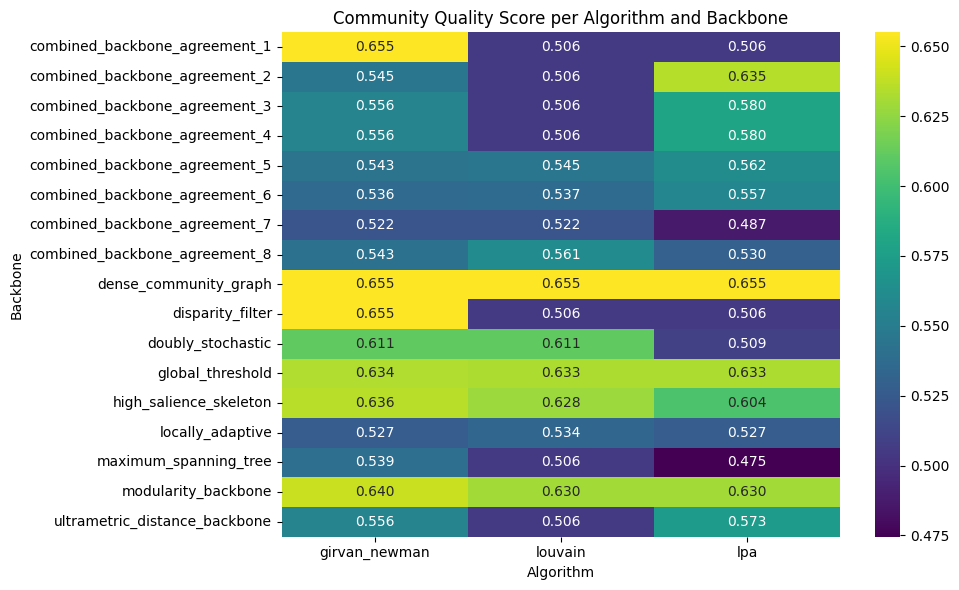

Index(['Algorithm', 'Backbone', 'Score'], dtype='object')
Backbone consistency across algorithms:
                                    mean       std
Backbone                                         
dense_community_graph          0.655035  0.000000
modularity_backbone            0.633518  0.005568
global_threshold               0.632948  0.000768
high_salience_skeleton         0.622446  0.016617
doubly_stochastic              0.576933  0.058735
combined_backbone_agreement_2  0.561882  0.066221
disparity_filter               0.555361  0.086320
combined_backbone_agreement_1  0.555269  0.086160
combined_backbone_agreement_5  0.550172  0.010091
combined_backbone_agreement_4  0.547117  0.037875
combined_backbone_agreement_3  0.547117  0.037875
ultrametric_distance_backbone  0.544840  0.035043
combined_backbone_agreement_8  0.544482  0.015898
combined_backbone_agreement_6  0.543572  0.011960
locally_adaptive               0.529501  0.004221
combined_backbone_agreement_7  0.510392  0.020505
m

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9d75a7aa0>


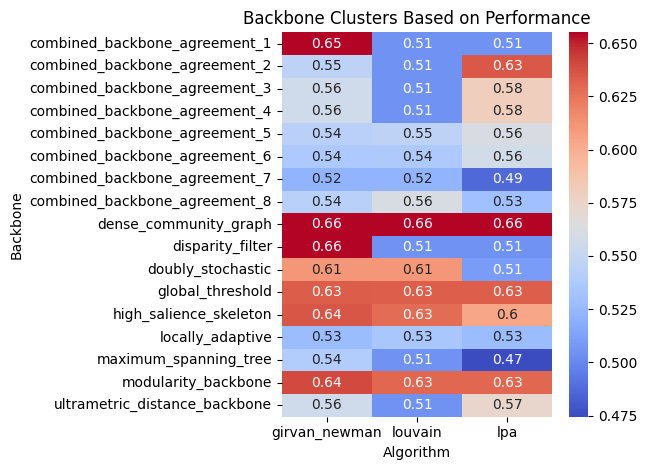

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
pivot = score_df.pivot(index='Backbone', columns='Algorithm', values='Score')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("Community Quality Score per Algorithm and Backbone")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()
print(score_df.columns)

import numpy as np

# Normalize score loss for better comparison
baseline = score_df[score_df['Backbone'] == 'Dense'][['Algorithm', 'Score']]
baseline = baseline.rename(columns={'Score': 'Score_Original'})

# Merge baseline into score_df on Algorithm
score_df = pd.merge(score_df, baseline, on='Algorithm', how='left')

import plotly.express as px

consistency = score_df.groupby("Backbone")["Score"].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("Backbone consistency across algorithms:\n", consistency)

from sklearn.cluster import KMeans

pivot = score_df.pivot(index="Backbone", columns="Algorithm", values="Score")
kmeans = KMeans(n_clusters=3, random_state=0).fit(pivot.fillna(0))
pivot["Cluster"] = kmeans.labels_

sns.heatmap(pivot.drop(columns='Cluster'), cmap="coolwarm", annot=True)
plt.title("Backbone Clusters Based on Performance")
plt.ylabel("Backbone")
plt.tight_layout()
plt.show()



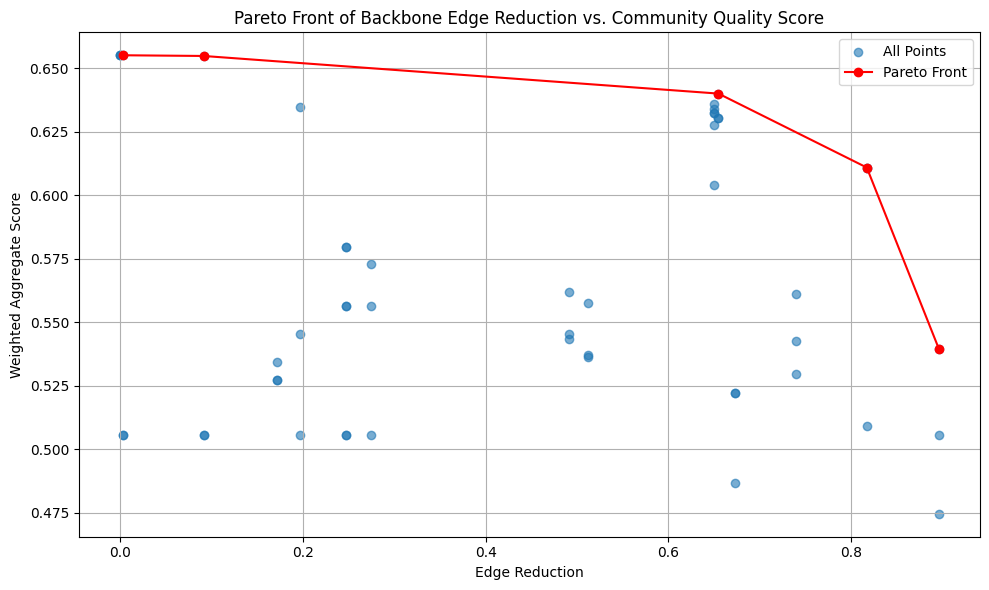

        Algorithm                       Backbone     Score  Score_Rank  \
50            lpa          dense_community_graph  0.655035         2.5   
4   girvan_newman               disparity_filter  0.655035         2.5   
33        louvain          dense_community_graph  0.655035         2.5   
16  girvan_newman          dense_community_graph  0.655035         2.5   
8   girvan_newman  combined_backbone_agreement_1  0.654758         5.0   
3   girvan_newman            modularity_backbone  0.639948         6.0   
1   girvan_newman         high_salience_skeleton  0.635851         7.0   
43            lpa  combined_backbone_agreement_2  0.634817         8.0   
0   girvan_newman               global_threshold  0.633835         9.0   
17        louvain               global_threshold  0.632504        10.5   
34            lpa               global_threshold  0.632504        10.5   
20        louvain            modularity_backbone  0.630304        12.5   
37            lpa            modularit

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

edge_counts = []
dense_edges = None  # To store number of edges in the dense graph

backbones = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone", "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8", "dense_community_graph" # Add dense graph here to load edges count!
]

for name in backbones:
    df = pd.read_csv(f'/content/dblp/filtered/{name}.csv')
    num_edges = len(df)

    if name == "dense_community_graph":
        dense_edges = num_edges  # Store the total edges in dense graph

    edge_counts.append({
        "Backbone": name,
        "Edges": num_edges
    })

edge_df = pd.DataFrame(edge_counts)

# Use dense_edges as baseline for edge reduction (instead of fixed 5000)
if dense_edges is None:
    raise ValueError("dense_community_graph edges not loaded!")

edge_df["Edge_Reduction"] = (dense_edges - edge_df["Edges"]) / dense_edges

records = []
base_dir = "/content/dblp/filtered"
algorithms = ["girvan_newman", "louvain", "lpa"]

# Correct iteration: loop over flat backbone list
for algo in algorithms:
    for bb in backbones:
        file_path = f"{base_dir}/{algo}_{bb}_scores.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

score_df = pd.DataFrame(records)

# Map Edge Reduction to score_df by Backbone
edge_reduction_dict = dict(zip(edge_df['Backbone'], edge_df['Edge_Reduction']))
score_df['Edge_Reduction'] = score_df['Backbone'].map(edge_reduction_dict)

# Pareto front function
def find_pareto_front(df, score_col='Score', edge_col='Edge_Reduction'):
    df_sorted = df.sort_values(by=[edge_col, score_col], ascending=[False, False]).reset_index(drop=True)
    pareto_front = []
    max_score = -np.inf
    for _, row in df_sorted.iterrows():
        if row[score_col] > max_score:
            pareto_front.append(row)
            max_score = row[score_col]
    return pd.DataFrame(pareto_front)

pareto_df = find_pareto_front(score_df)

# Plot Pareto front
plt.figure(figsize=(10,6))
plt.scatter(score_df['Edge_Reduction'], score_df['Score'], label='All Points', alpha=0.6)
plt.plot(pareto_df['Edge_Reduction'], pareto_df['Score'], color='red', marker='o', linestyle='-', label='Pareto Front')
plt.xlabel('Edge Reduction')
plt.ylabel('Weighted Aggregate Score')
plt.title('Pareto Front of Backbone Edge Reduction vs. Community Quality Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Rank by Score (descending: higher is better)
score_df['Score_Rank'] = score_df['Score'].rank(ascending=False)

# Rank by Edge Reduction (descending: higher is better)
score_df['Edge_Reduction_Rank'] = score_df['Edge_Reduction'].rank(ascending=False)

# Print the results sorted by Score first
print(score_df.sort_values('Score_Rank')[['Algorithm', 'Backbone', 'Score', 'Score_Rank', 'Edge_Reduction', 'Edge_Reduction_Rank']])




Scores saved to /content/dblp/filtered/girvan_newman_global_threshold_scores_v2.csv
Overall weighted score for girvan_newman_global_threshold: 0.03262527642710891

Scores saved to /content/dblp/filtered/louvain_global_threshold_scores_v2.csv
Overall weighted score for louvain_global_threshold: 0.032682598774643724

Scores saved to /content/dblp/filtered/lpa_global_threshold_scores_v2.csv
Overall weighted score for lpa_global_threshold: 0.032682598774643724

Scores saved to /content/dblp/filtered/girvan_newman_high_salience_skeleton_scores_v2.csv
Overall weighted score for girvan_newman_high_salience_skeleton: 0.03441404368821842

Scores saved to /content/dblp/filtered/louvain_high_salience_skeleton_scores_v2.csv
Overall weighted score for louvain_high_salience_skeleton: 0.03400251053219407

Scores saved to /content/dblp/filtered/lpa_high_salience_skeleton_scores_v2.csv
Overall weighted score for lpa_high_salience_skeleton: 0.03384373118061112

Scores saved to /content/dblp/filtered/gir

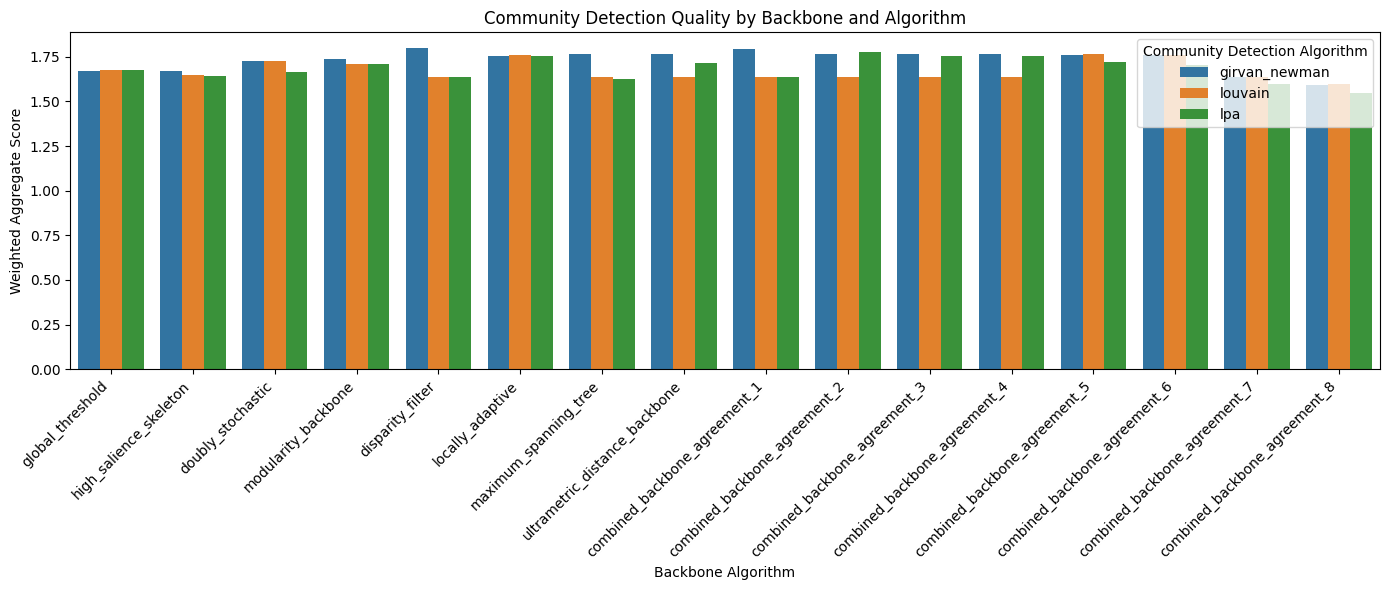

In [ ]:

import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# Calculating the Goodness Score
# ------------------------------

def separability(G, S):
    subG = G.subgraph(S)
    internal_edges = subG.number_of_edges()
    external_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    total_edges = internal_edges + external_edges
    return internal_edges / total_edges if total_edges > 0 else 0

def density(G, S):
    n = len(S)
    if n < 2:
        return 0
    internal_edges = G.subgraph(S).number_of_edges()
    possible_edges = n * (n - 1) / 2
    return internal_edges / possible_edges if possible_edges > 0 else 0

def cohesiveness(G, S):
    subG = G.subgraph(S)
    internal_edges = subG.number_of_edges()
    boundary_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return internal_edges / (internal_edges + boundary_edges) if (internal_edges + boundary_edges) > 0 else 0

def clustering_coefficient(G, S):
    triangles = 0
    triplets = 0
    for u in S:
        neighbors_u = set(G.neighbors(u)).intersection(S)
        for v, w in combinations(neighbors_u, 2):
            if G.has_edge(v, w):
                triangles += 1
        triplets += len(neighbors_u) * (len(neighbors_u) - 1) / 2
    return triangles / triplets if triplets > 0 else 0

# ------------------------------
# Compute the scores for communities based only on the new metrics
# ------------------------------

def compute_all_scores_v2(G, S):
    scores = {
        'separability': separability(G, S),
        'density': density(G, S),
        'cohesiveness': cohesiveness(G, S),
        'clustering_coefficient': clustering_coefficient(G, S),
    }
    return scores

# ------------------------------
# AHP weighting setup for the new metrics
# ------------------------------

metrics_v2 = ['separability', 'density', 'cohesiveness', 'clustering_coefficient']

# Example pairwise comparison matrix (4x4) for these metrics — adjust as needed
# Rows and columns correspond to metrics_v2 in the same order
ahp_matrix_v2 = np.array([
    [1,    1/3,  1/2,  1/4],
    [3,    1,    2,    1/2],
    [2,    1/2,  1,    1/3],
    [4,    2,    3,    1]
])

def calculate_ahp_weights(matrix):
    col_sum = np.sum(matrix, axis=0)
    normalized = matrix / col_sum
    weights = np.mean(normalized, axis=1)
    weights /= np.sum(weights)
    return weights

ahp_weights_v2 = calculate_ahp_weights(ahp_matrix_v2)

# ------------------------------
# Aggregate and weight the scores based only on the new metrics with AHP weighting
# ------------------------------

def aggregate_and_weight_scores_v2(df, G, weight_size=True):
    invert_metrics = ['separability']  # Assuming lower separability is worse, so invert

    scaler = MinMaxScaler()
    df_metrics = df[metrics_v2].copy()

    # Normalize and invert selected metrics
    for m in invert_metrics:
        if m in df_metrics.columns:
            vals = df_metrics[[m]].values
            vals_scaled = scaler.fit_transform(vals)
            df_metrics[m] = 1 - vals_scaled.flatten()
        else:
            df_metrics[m] = 0

    # Normalize remaining metrics
    for m in metrics_v2:
        if m not in invert_metrics and m in df_metrics.columns:
            vals = df_metrics[[m]].values
            df_metrics[m] = scaler.fit_transform(vals).flatten()

    # Apply AHP weights (dot product)
    df['aggregate_score'] = df_metrics.values.dot(ahp_weights_v2)

    # Normalize by total number of edges in G
    total_edges = G.number_of_edges()
    if total_edges > 0:
        df['aggregate_score'] = df['aggregate_score'] / total_edges

    if weight_size:
        df['weighted_score'] = df['aggregate_score'] * df['community_size']
    else:
        df['weighted_score'] = df['aggregate_score']

    return df


# ------------------------------
# Read and process the community partitions
# ------------------------------

def read_communities_from_txt(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            nodes = list(map(int, line.strip().split()))
            communities.append(nodes)
    return communities

def compute_scores_for_partition(G, partition):
    data = []
    for i, community in enumerate(partition):
        scores = compute_all_scores_v2(G, community)
        scores['community_id'] = i
        scores['community_size'] = len(community)
        data.append(scores)
    df = pd.DataFrame(data)
    return df

def process_community_scores(G, communities):
    scores_df = compute_scores_for_partition(G, communities)
    scores_df = aggregate_and_weight_scores_v2(scores_df, G)  # pass G here
    return scores_df

def save_scores_to_csv(df, outpath):
    df.to_csv(outpath, index=False)
    print(f"Scores saved to {outpath}")

# ------------------------------
# Main processing loop
# ------------------------------

# Assume G is your NetworkX graph, e.g.
# G = nx.read_edgelist('your_graph.edgelist', nodetype=int)

for name in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",
     "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8"
]:
    for algo in ["girvan_newman", "louvain", "lpa"]:
        txt_file = f'/content/community_outputs/{algo}_{name}.txt'
        output_csv = f'/content/dblp/filtered/{algo}_{name}_scores_v2.csv'

        communities = read_communities_from_txt(txt_file)
        scores_df = process_community_scores(G, communities)
        save_scores_to_csv(scores_df, output_csv)

        overall_score = scores_df['weighted_score'].sum()
        print(f"Overall weighted score for {algo}_{name}: {overall_score}\n")


for algo in ["girvan_newman", "louvain", "lpa"]:
    txt_file = f'/content/community_outputs/{algo}_dense_community_graph.txt'
    output_csv = f'/content/dblp/filtered/{algo}_dense_community_graph_scores_v2.csv'

    communities = read_communities_from_txt(txt_file)
    scores_df = process_community_scores(G, communities)
    save_scores_to_csv(scores_df, output_csv)

    overall_score = scores_df['weighted_score'].sum()
    print(f"Overall weighted score for {algo}_dense_community_graph: {overall_score}\n")


records = []
base_dir = "/content/dblp/filtered"
# Loop through all combinations and collect scores
for algo in ["girvan_newman", "louvain", "lpa"]:
    for bb in [
     "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",
     "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8"
]:
        file_path = f"{base_dir}/{algo}_{bb}_scores_v2.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score =  ((df['aggregate_score'] * df['community_size']).sum())*10000/ df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

# Include dense_community_graph baseline
for algo in algos:
    file_path = f"{base_dir}/{algo}_dense_community_graph_scores_v2.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        score = ((df['aggregate_score'] * df['community_size']).sum())*10000/ df['community_size'].sum()
        records.append({'Algorithm': algo, 'Backbone': 'dense_community_graph', 'Score': score})

# Convert to DataFrame
score_df = pd.DataFrame(records)
print(score_df)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=score_df, x='Backbone', y='Score', hue='Algorithm')
plt.xticks(rotation=45, ha='right')
plt.title("Community Detection Quality by Backbone and Algorithm")
plt.ylabel("Weighted Aggregate Score")
plt.xlabel("Backbone Algorithm")
plt.legend(title="Community Detection Algorithm")
plt.tight_layout()
plt.show()


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9dd9a0dd0>


0     48
1     48
2     48
3     48
4     48
5     48
6     48
7     48
8     48
9     48
10    48
11    48
12    48
13    48
14    48
15    48
16    48
17    48
18    48
19    48
20    48
21    48
22    48
23    48
24    48
25    48
26    48
27    48
28    48
29    48
30    48
31    48
32    48
33    48
34    48
35    48
36    48
37    48
38    48
39    48
40    48
41    48
42    48
43    48
44    48
45    48
46    48
47    48
Name: Edge_Count, dtype: int64


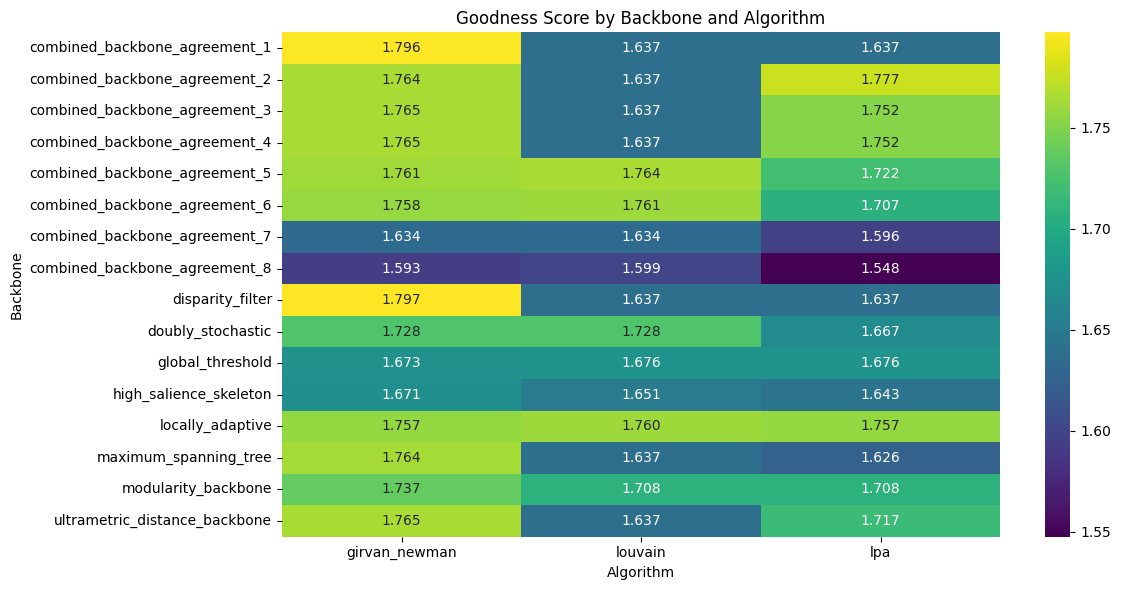

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9e2cfe990>


Backbone Consistency Across Algorithms:
                                mean    std
Backbone                                   
locally_adaptive               1.758  0.002
combined_backbone_agreement_5  1.749  0.024
combined_backbone_agreement_6  1.742  0.030
combined_backbone_agreement_2  1.726  0.077
combined_backbone_agreement_3  1.718  0.070
combined_backbone_agreement_4  1.718  0.070
modularity_backbone            1.718  0.017
doubly_stochastic              1.708  0.035
ultrametric_distance_backbone  1.707  0.064
disparity_filter               1.691  0.092
combined_backbone_agreement_1  1.690  0.091
maximum_spanning_tree          1.676  0.077
global_threshold               1.675  0.002
high_salience_skeleton         1.655  0.014
combined_backbone_agreement_7  1.621  0.022
combined_backbone_agreement_8  1.580  0.028
Backbone Cluster Assignments:
Backbone
combined_backbone_agreement_1    1
combined_backbone_agreement_2    1
combined_backbone_agreement_3    1
combined_backbone_agreem

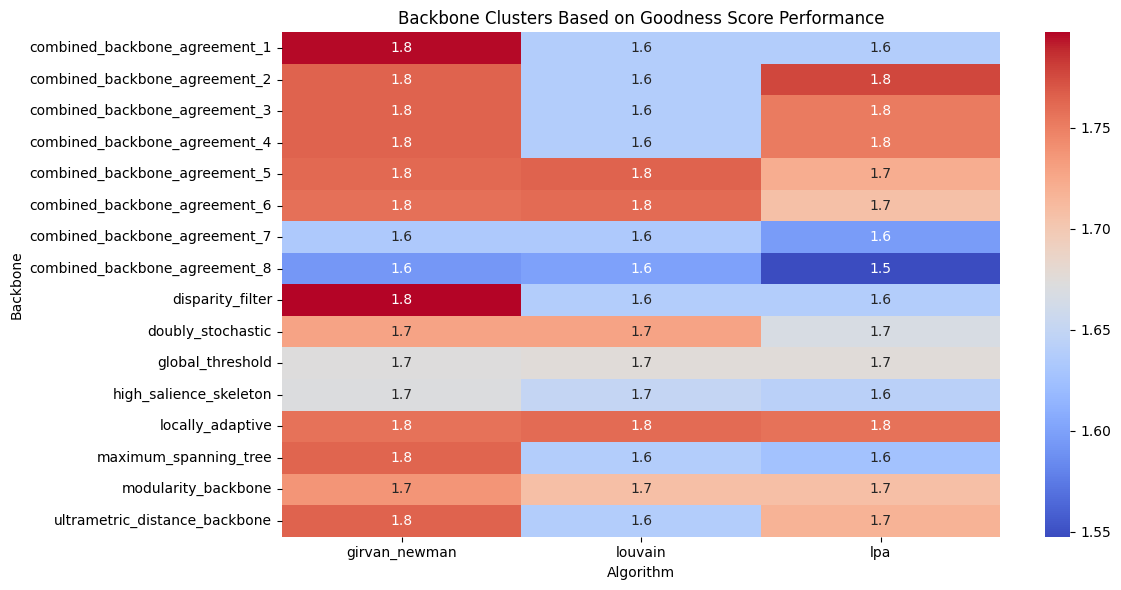

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

# Load your goodness score DataFrame here
# Replace this with the actual loading step
# Example: score_df = pd.read_csv("/path/to/your/score_df.csv")

# Compute baseline using dense_community_graph
baseline = score_df[score_df['Backbone'] == 'dense_community_graph'][['Algorithm', 'Score']]
baseline = baseline.set_index('Algorithm')['Score']
# Example edges_df:
# columns: Backbone, Algorithm, Edge_Count

score_df["Edge_Count"] = len(score_df["Backbone"])
print(score_df["Edge_Count"])
# --------------------------------------------------
# Compute Edge Reduction Percentage
# --------------------------------------------------

if "Edge_Count" in score_df.columns:
    # Baseline edge count from the dense version
    baseline_edges = score_df[score_df["Backbone"] == "dense_community_graph"]["Edge_Count"].mean()

    # Edge reduction percentage (fraction of edges removed)
    score_df["Edge_Reduction_Perc"] = 100 * (1 - score_df["Edge_Count"] / baseline_edges)
else:
    print("⚠️ Warning: 'Edge_Count' column not found. Skipping edge reduction analysis.")

# Heatmap of goodness scores
pivot = score_df.pivot(index='Backbone', columns='Algorithm', values='Score')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("Goodness Score by Backbone and Algorithm")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()


# Consistency across algorithms
consistency = score_df.groupby("Backbone")["Score"].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("Backbone Consistency Across Algorithms:")
print(consistency.round(3))

# Clustering backbones based on algorithm scores
pivot = score_df.pivot(index="Backbone", columns="Algorithm", values="Score").fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42).fit(pivot)
pivot['Cluster'] = kmeans.labels_

# Show cluster assignments
print("Backbone Cluster Assignments:")
print(pivot['Cluster'])

# Cluster heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.drop(columns='Cluster'), cmap="coolwarm", annot=True)
plt.title("Backbone Clusters Based on Goodness Score Performance")
plt.ylabel("Backbone")
plt.tight_layout()
plt.show()
# Rank by Score (higher is better)


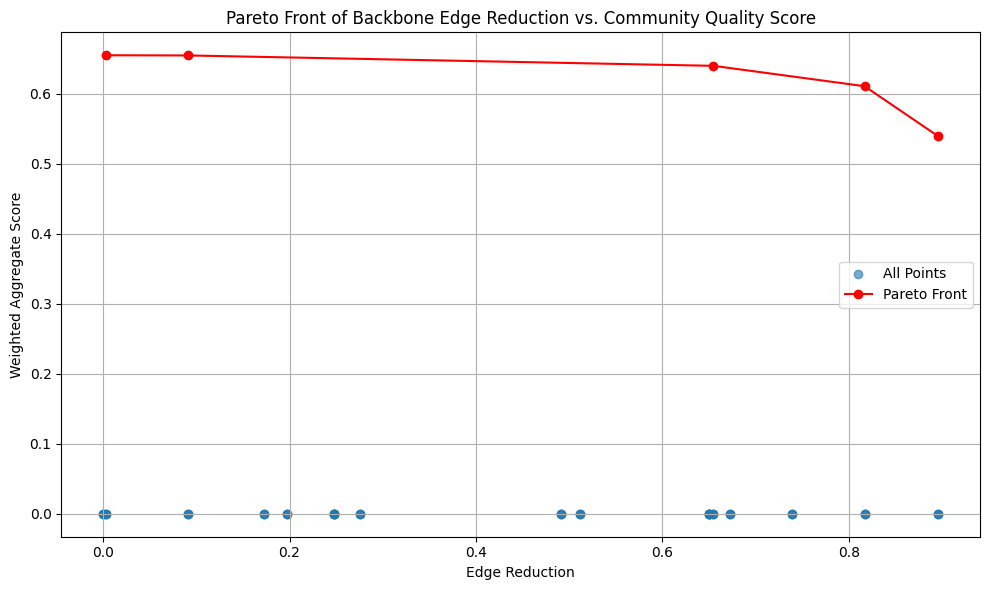

        Algorithm                       Backbone     Score  Score_Rank  \
4   girvan_newman               disparity_filter  0.000180         1.0   
50            lpa          dense_community_graph  0.000180         3.0   
33        louvain          dense_community_graph  0.000180         3.0   
16  girvan_newman          dense_community_graph  0.000180         3.0   
8   girvan_newman  combined_backbone_agreement_1  0.000180         5.0   
43            lpa  combined_backbone_agreement_2  0.000178         6.0   
11  girvan_newman  combined_backbone_agreement_4  0.000176         8.0   
10  girvan_newman  combined_backbone_agreement_3  0.000176         8.0   
7   girvan_newman  ultrametric_distance_backbone  0.000176         8.0   
29        louvain  combined_backbone_agreement_5  0.000176        10.5   
9   girvan_newman  combined_backbone_agreement_2  0.000176        10.5   
6   girvan_newman          maximum_spanning_tree  0.000176        12.0   
12  girvan_newman  combined_backbone_a

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define backbones
backbones = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",
     "combined_backbone_agreement_1", "combined_backbone_agreement_2", "combined_backbone_agreement_3", "combined_backbone_agreement_4", "combined_backbone_agreement_5", "combined_backbone_agreement_6", "combined_backbone_agreement_7", "combined_backbone_agreement_8",
    "dense_community_graph"
]

# Load edge counts
edge_counts = []
dense_edges = None

for name in backbones:
    df = pd.read_csv(f'/content/dblp/filtered/{name}.csv')
    num_edges = len(df)
    if name == "dense_community_graph":
        dense_edges = num_edges
    edge_counts.append({"Backbone": name, "Edges": num_edges})

edge_df = pd.DataFrame(edge_counts)

# Compute edge reduction
if dense_edges is None:
    raise ValueError("dense_community_graph edges not loaded!")
edge_df["Edge_Reduction"] = (dense_edges - edge_df["Edges"]) / dense_edges

# Load scores
records = []
base_dir = "/content/dblp/filtered"
algorithms = ["girvan_newman", "louvain", "lpa"]

for algo in algorithms:
    for bb in backbones:
        file_path = f"{base_dir}/{algo}_{bb}_scores_v2.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

score_df = pd.DataFrame(records)

# Merge edge data
score_df = score_df.merge(edge_df[['Backbone', 'Edges', 'Edge_Reduction']], on='Backbone', how='left')
score_df.rename(columns={'Edges': 'Edge_Count'}, inplace=True)

# Pareto front function
def find_pareto_front(df, score_col='Score', edge_col='Edge_Reduction'):
    df_sorted = df.sort_values(by=[edge_col, score_col], ascending=[False, False]).reset_index(drop=True)
    pareto_front = []
    max_score = -np.inf
    for _, row in df_sorted.iterrows():
        if row[score_col] > max_score:
            pareto_front.append(row)
            max_score = row[score_col]
    return pd.DataFrame(pareto_front)

# Compute Pareto front
# Plot Pareto front
plt.figure(figsize=(10,6))
plt.scatter(score_df['Edge_Reduction'], score_df['Score'], label='All Points', alpha=0.6)
plt.plot(pareto_df['Edge_Reduction'], pareto_df['Score'], color='red', marker='o', linestyle='-', label='Pareto Front')
plt.xlabel('Edge Reduction')
plt.ylabel('Weighted Aggregate Score')
plt.title('Pareto Front of Backbone Edge Reduction vs. Community Quality Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Rank by Score (descending: higher is better)
score_df['Score_Rank'] = score_df['Score'].rank(ascending=False)

# Rank by Edge Reduction (descending: higher is better)
score_df['Edge_Reduction_Rank'] = score_df['Edge_Reduction'].rank(ascending=False)

# Print the results sorted by Score first
print(score_df.sort_values('Score_Rank')[['Algorithm', 'Backbone', 'Score', 'Score_Rank', 'Edge_Reduction', 'Edge_Reduction_Rank']])



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9dff80440>


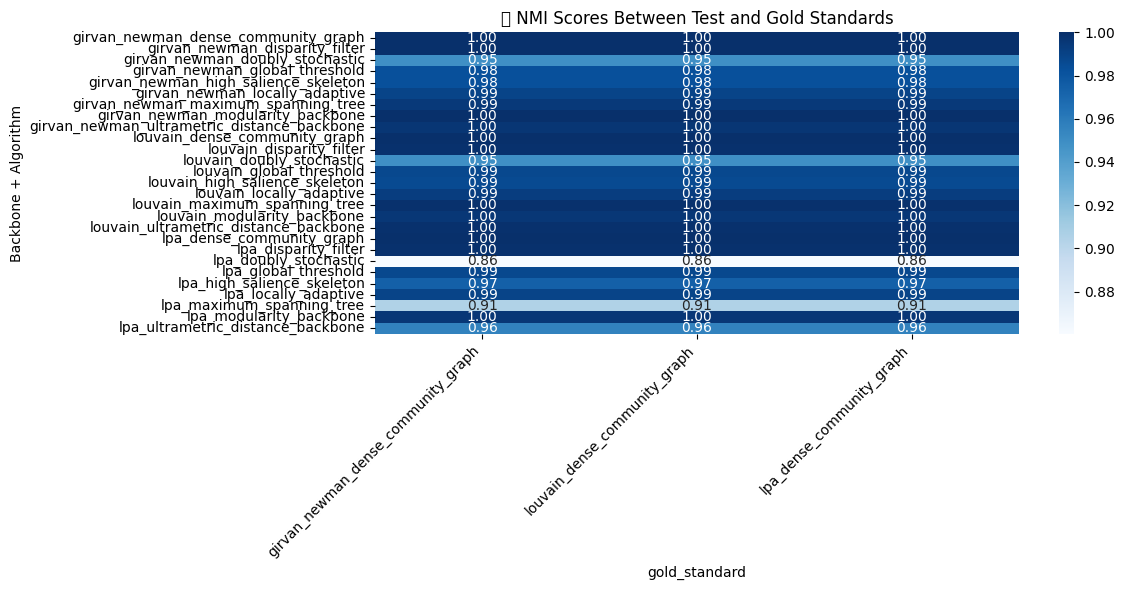

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ce9d738e990>


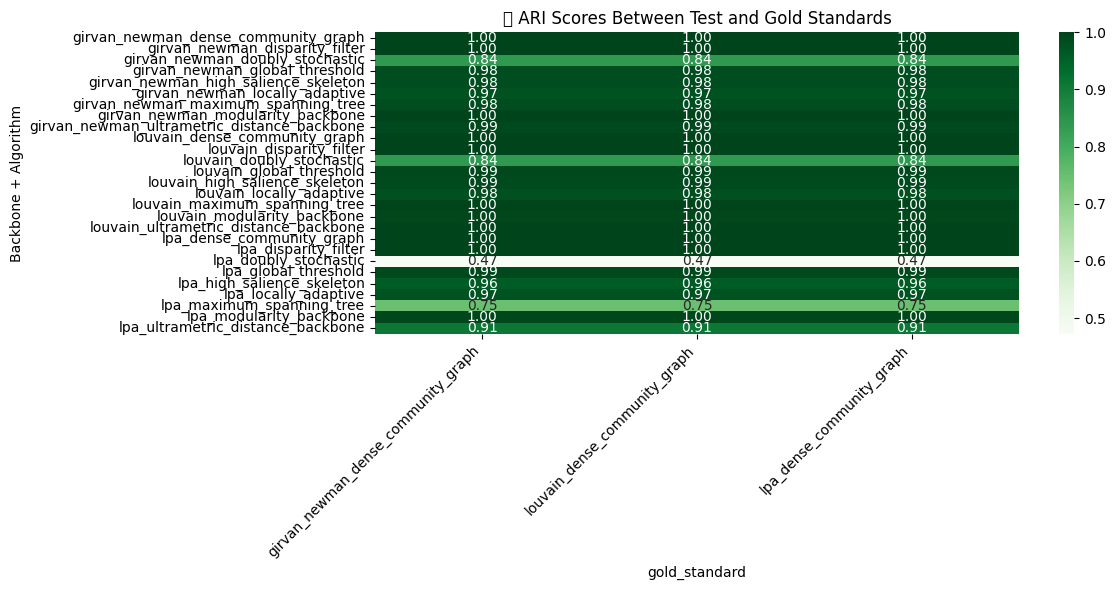

In [ ]:
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score

# Computing the NMI/ARI Score between baseline graph and the backboned graph
def read_community_from_file(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            community = list(map(int, line.strip().split()))
            communities.append(community)
    return communities

def community_to_node_assignment(communities):
    node_to_community = {}
    for community_id, community in enumerate(communities):
        for node in community:
            node_to_community[node] = community_id
    return node_to_community

def filter_nodes_by_community(community_structure, reference_map):
    node_set_original = set(reference_map.keys())
    filtered_community_structure = []
    for community in community_structure:
        filtered = [node for node in community if node in node_set_original]
        if filtered:
            filtered_community_structure.append(filtered)
    return filtered_community_structure

def compute_nmi_ari(gold_file, test_file):
    gold_comms = read_community_from_file(gold_file)
    gold_map = community_to_node_assignment(gold_comms)

    test_comms = read_community_from_file(test_file)
    filtered_test = filter_nodes_by_community(test_comms, gold_map)
    test_map = community_to_node_assignment(filtered_test)

    common_nodes = set(gold_map.keys()).intersection(test_map.keys())
    y_true = [gold_map[n] for n in common_nodes]
    y_pred = [test_map[n] for n in common_nodes]

    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    return nmi, ari

# Paths to gold standards
gold_files = {
    "girvan_newman": "/content/community_outputs/girvan_newman_dense_community_graph.txt",
    "louvain": "/content/community_outputs/louvain_dense_community_graph.txt",
    "lpa": "/content/community_outputs/lpa_dense_community_graph.txt"
}

# Loop through all variants and compare to each gold file
backbones = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",
    "dense_community_graph"
]

algorithms = ["girvan_newman", "louvain", "lpa"]

results = []

all_ks_results = []

for algo in algorithms:
    for name in backbones:
        test_file = f'/content/community_outputs/{algo}_{name}.txt'
        for gold_algo, gold_path in gold_files.items():
            try:
                nmi, ari = compute_nmi_ari(gold_path, test_file)
                results.append({
                    "test_file": f"{algo}_{name}",
                    "gold_standard": f"{gold_algo}_dense_community_graph",
                    "NMI": round(nmi, 4),
                    "ARI": round(ari, 4)
                })
            except Exception as e:
                results.append({
                    "test_file": f"{algo}_{name}",
                    "gold_standard": f"{gold_algo}_dense_community_graph",
                    "NMI": "ERROR",
                    "ARI": "ERROR",
                    "Error": str(e)
                })

results_df = pd.DataFrame(results)
valid_results = results_df[~results_df['NMI'].isin(["ERROR"])].copy()
valid_results['NMI'] = valid_results['NMI'].astype(float)
valid_results['ARI'] = valid_results['ARI'].astype(float)

# Pivot for heatmaps
nmi_heatmap = valid_results.pivot(index='test_file', columns='gold_standard', values='NMI')
ari_heatmap = valid_results.pivot(index='test_file', columns='gold_standard', values='ARI')

# Plot NMI heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(nmi_heatmap, annot=True, fmt=".2f", cmap="Blues")
plt.title("🔍 NMI Scores Between Test and Gold Standards")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Backbone + Algorithm")
plt.tight_layout()
plt.show()

# Plot ARI heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(ari_heatmap, annot=True, fmt=".2f", cmap="Greens")
plt.title("🔍 ARI Scores Between Test and Gold Standards")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Backbone + Algorithm")
plt.tight_layout()
plt.show()


Adding Noise to the Graph

In [ ]:
import pandas as pd
import networkx as nx
import random
import numpy as np

def add_synthetic_noisy_edges(df, noise_ratio=1.0, weight_range=(0, 0.5), noise_type='random', seed=42):
    random.seed(seed)
    np.random.seed(seed)

    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight')
    nodes = list(G.nodes())
    original_edges = set((min(u, v), max(u, v)) for u, v in G.edges())

    num_synthetic_edges = int(len(original_edges) * noise_ratio)
    synthetic_edges = []
    attempts = 0
    max_attempts = num_synthetic_edges * 10

    while len(synthetic_edges) < num_synthetic_edges and attempts < max_attempts:
        if noise_type == 'random':
            u, v = random.sample(nodes, 2)
        elif noise_type == 'high_degree':
            degrees = dict(G.degree())
            probs = np.array([degrees[n] for n in nodes])
            probs = probs / probs.sum()
            u = np.random.choice(nodes, p=probs)
            v = np.random.choice(nodes, p=probs)
            while u == v:
                v = np.random.choice(nodes, p=probs)
        else:
            raise ValueError("Invalid noise_type. Use 'random' or 'high_degree'.")

        edge = (min(u, v), max(u, v))
        if edge not in original_edges:
            weight = np.random.uniform(*weight_range)
            synthetic_edges.append({'source': edge[0], 'target': edge[1], 'weight': weight})
            original_edges.add(edge)
        attempts += 1

    synthetic_df = pd.DataFrame(synthetic_edges)
    combined_df = pd.concat([df[['source', 'target', 'weight']], synthetic_df], ignore_index=True)

    return combined_df

# Load original graph
df = pd.read_csv("/content/dblp/filtered/dense_community_graph.csv")

# Variant 1: Low-weight random noise (default)
g1 = add_synthetic_noisy_edges(df, noise_ratio=1.0, weight_range=(0, 0.5), noise_type='random')
g1.to_csv("/content/dblp/noisy_random_low.csv", index=False)

# Variant 2: High-weight noise
g2 = add_synthetic_noisy_edges(df, noise_ratio=1.0, weight_range=(0.5, 2.0), noise_type='random')
g2.to_csv("/content/dblp/noisy_random_high.csv", index=False)

# Variant 3: Biased noise toward high-degree nodes
g3 = add_synthetic_noisy_edges(df, noise_ratio=1.0, weight_range=(0, 0.5), noise_type='high_degree')
g3.to_csv("/content/dblp/noisy_high_degree.csv", index=False)




In [ ]:
import pandas as pd
import networkx as nx
import netbone as nb

# Load and clean CSV, only noisy_random_low is being used here
df = pd.read_csv('/content/dblp/noisy_random_low.csv')
df.columns = df.columns.str.strip().str.lower()
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# Build graph
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight')
G = nx.relabel_nodes(G, lambda x: str(x))  # optional but may avoid issues

In [ ]:
from netbone.compare import Compare
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Setup as you have it
framework = Compare()
framework.set_network(G)

from netbone.filters import fraction_filter
fractions = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(fraction_filter, fractions)

from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, weight_entropy, transitivity, number_connected_components

gt = nb.global_threshold(G)
hss = nb.high_salience_skeleton(G)
ds = nb.doubly_stochastic(G)
mb = nb.modularity_backbone(G)
framework.add_backbone(gt)
framework.add_backbone(hss)
framework.add_backbone(ds)
framework.add_backbone(mb)

framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
framework.add_property('Weight Entropy', weight_entropy)
framework.add_property('Transitivity', transitivity)
framework.add_property('Number of Connected Components', number_connected_components)

# 1. Get progression results for all properties
results = framework.properties_progression()

metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability', 'Weight Entropy', 'Transitivity', 'Number of Connected Components']

# 2. Normalize each metric DataFrame per backbone column independently
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# --- AHP weighting ---

# Pairwise comparison matrix based on your importance judgments
pairwise_matrix = np.array([
# NF   EF   WF   Den  Deg  Rea  Ent  Tra  CC
 [1,   1,   1,   5,   5,   7,   8,   8,   6],   # Node Fraction
 [1,   1,   1,   5,   5,   6,   7,   7,   6],   # Edge Fraction
 [1,   1,   1,   6,   6,   7,   7,   7,   6],   # Weight Fraction
 [1/5, 1/5, 1/6, 1,   3,   4,   5,   5,   4],   # Density
 [1/5, 1/5, 1/6, 1/3, 1,   3,   4,   4,   3],   # Avg Degree
 [1/7, 1/6, 1/7, 1/4, 1/3, 1,   3,   3,   3],   # Reachability
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1,   2,   2],   # Weight Entropy
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1/2, 1,   2],   # Transitivity
 [1/6, 1/6, 1/6, 1/4, 1/3, 1/3, 1/2, 1/2, 1]    # Connected Components
])
# Calculate principal eigenvector for weights
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_index = np.argmax(eigvals.real)
principal_eigvec = eigvecs[:, max_index].real

# Normalize eigenvector so sum(weights) = 1
weights = principal_eigvec / principal_eigvec.sum()

# Map weights to metrics for clarity
weights_dict = dict(zip(metrics, weights))

print("AHP Weights:")
for m, w in weights_dict.items():
    print(f"{m}: {w:.3f}")

# 3. Aggregate normalized metrics using AHP weights
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

prefer_moderate = ['Edge Fraction', 'Average Degree', 'Density', 'Transitivity', 'Number of Connected Components']

for metric in metrics:
    norm_df = normalized_metrics[metric]

    if metric in prefer_moderate:
        # Apply bell-shaped preference for moderate values
        adjusted_df = 1 - (2 * norm_df - 1) ** 2
        aggregate_scores += adjusted_df * weights_dict[metric]
    else:
        # Keep maximizing for metrics where high is good
        aggregate_scores += norm_df * weights_dict[metric]


# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)



In [ ]:
#Computing the best optimal score for threshold to yield the highest possible aggregate score
from netbone.compare import Compare
framework = Compare()
framework.set_network(G)
from netbone.filters import threshold_filter, boolean_filter
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(threshold_filter, thresholds)
from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, transitivity, weight_entropy, number_connected_components

df =nb.disparity(G)
lans = nb.lans(G)
framework.add_backbone(df)
framework.add_backbone(lans)
framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
framework.add_property('Weight Entropy', weight_entropy)
framework.add_property('Transitivity', transitivity)
framework.add_property('Number of Connected Components', number_connected_components)
# After your setup...

results = framework.properties_progression()

metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability', 'Weight Entropy', 'Transitivity', 'Number of Connected Components']

# 2. Normalize each metric DataFrame per backbone column independently
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# --- AHP weighting ---

# Pairwise comparison matrix based on your importance judgments
pairwise_matrix = np.array([
# NF   EF   WF   Den  Deg  Rea  Ent  Tra  CC
 [1,   1,   1,   5,   5,   7,   8,   8,   6],   # Node Fraction
 [1,   1,   1,   5,   5,   6,   7,   7,   6],   # Edge Fraction
 [1,   1,   1,   6,   6,   7,   7,   7,   6],   # Weight Fraction
 [1/5, 1/5, 1/6, 1,   3,   4,   5,   5,   4],   # Density
 [1/5, 1/5, 1/6, 1/3, 1,   3,   4,   4,   3],   # Avg Degree
 [1/7, 1/6, 1/7, 1/4, 1/3, 1,   3,   3,   3],   # Reachability
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1,   2,   2],   # Weight Entropy
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1/2, 1,   2],   # Transitivity
 [1/6, 1/6, 1/6, 1/4, 1/3, 1/3, 1/2, 1/2, 1]    # Connected Components
])
# Calculate principal eigenvector for weights
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_index = np.argmax(eigvals.real)
principal_eigvec = eigvecs[:, max_index].real

# Normalize eigenvector so sum(weights) = 1
weights = principal_eigvec / principal_eigvec.sum()

# Map weights to metrics for clarity
weights_dict = dict(zip(metrics, weights))

print("AHP Weights:")
for m, w in weights_dict.items():
    print(f"{m}: {w:.3f}")

# 3. Aggregate normalized metrics using AHP weights
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

prefer_moderate = ['Edge Fraction', 'Average Degree', 'Density', 'Transitivity', 'Number of Connected Components']

for metric in metrics:
    norm_df = normalized_metrics[metric]

    if metric in prefer_moderate:
        # Apply bell-shaped preference for moderate values
        adjusted_df = 1 - (2 * norm_df - 1) ** 2
        aggregate_scores += adjusted_df * weights_dict[metric]
    else:
        # Keep maximizing for metrics where high is good
        aggregate_scores += norm_df * weights_dict[metric]

# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)

In [ ]:
gt = nb.global_threshold(G)
global_threshold = fraction_filter(gt, 0.35)
hss = nb.high_salience_skeleton(G)
high_salience_skeleton = fraction_filter(hss, 0.3)
ds = nb.doubly_stochastic(G)
doubly_stochastic = fraction_filter(ds, 0.3)
mb = nb.modularity_backbone(G)
modularity_backbone = fraction_filter(mb, 0.35)
df =nb.disparity(G)
disparity_filter = threshold_filter(df, 0.25)
lans = nb.lans(G)
locally_adaptive = threshold_filter(lans, 0.4)
mst = nb.maximum_spanning_tree(G)
maximum_spanning_tree = boolean_filter(mst)
hb = nb.h_backbone(G)
h_backbone = boolean_filter(hb)
ud = nb.ultrametric_distance_backbone(G)
ultrametric_distance = boolean_filter(ud)

In [ ]:
import pandas as pd
import os

# Helper function to save graph edges to CSV
def save_graph_edges_to_csv(graph, filepath):
    # Extract edges with data
    edges = list(graph.edges(data=True))

    # Prepare data for DataFrame
    rows = []
    for u, v, data in edges:
        row = {
            'source': u,
            'target': v,
            # Save weight if exists, else default 1
            'weight': data.get('weight', 1)
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Create dirs if not exist
    df.to_csv(filepath, index=False)
    print(f"Saved to {filepath}")

# Example usage with your filters:

save_graph_edges_to_csv(disparity_filter, '/content/dblp/filtered/noisy/disparity_filter.csv')
save_graph_edges_to_csv(locally_adaptive, '/content/dblp/filtered/noisy/locally_adaptive.csv')
save_graph_edges_to_csv(maximum_spanning_tree, '/content/dblp/filtered/noisy/maximum_spanning_tree.csv')
save_graph_edges_to_csv(global_threshold, '/content/dblp/filtered/noisy/global_threshold.csv')
save_graph_edges_to_csv(high_salience_skeleton, '/content/dblp/filtered/noisy/high_salience_skeleton.csv')
save_graph_edges_to_csv(doubly_stochastic, '/content/dblp/filtered/noisy/doubly_stochastic.csv')
save_graph_edges_to_csv(modularity_backbone, '/content/dblp/filtered/noisy/modularity_backbone.csv')
save_graph_edges_to_csv(h_backbone, '/content/dblp/filtered/noisy/h_backbone.csv')
save_graph_edges_to_csv(ultrametric_distance, '/content/dblp/filtered/noisy/ultrametric_distance_backbone.csv')


In [ ]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd

os.makedirs("community_outputs", exist_ok=True)

summary_data = []

#generate backbones for the dblp graphs

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone"]:
    bb = f"/content/dblp/filtered/noisy/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume already filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(com) for com in first_split]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"/content/dblp/filtered/noisy/girvan_newman_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Girvan-Newman communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/dblp/noisy_random_low.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/dblp/filtered/noisy/girvan_newman_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("/content/dblp/filtered/noisy/girvan_newman.csv", index=False)

In [ ]:
from networkx.algorithms.community import louvain_communities

summary_data = []

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone"]:
    bb = f"/content/dblp/filtered/noisy/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = louvain_communities(G, seed=42)
        node_groups = [list(c) for c in communities]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"/content/dblp/filtered/noisy/louvain_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Louvain communities: {name}")
    plt.tight_layout()
    plt.show()


csv_path = "/content/dblp/noisy_random_low.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = louvain_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/dblp/filtered/noisy/louvain_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Louvain: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Louvain execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })


# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("/content/dblp/filtered/noisy/louvain.csv", index=False)




In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from networkx.algorithms.community import label_propagation_communities

summary_data = []
os.makedirs("community_outputs", exist_ok=True)

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "h_backbone", "ultrametric_distance_backbone"]:
    file_path = f"/content/dblp/filtered/noisy/{name}.csv"

    try:
        df = pd.read_csv(file_path)
        G = nx.from_pandas_edgelist(df)
    except Exception as e:
        print(f"Skipping {name} due to file/read error: {e}")
        continue

    if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        # Run Label Propagation
        communities = label_propagation_communities(G)
        node_groups = [list(c) for c in communities]

    except Exception as e:
        print(f"Skipping {name} due to LPA error: {e}")
        continue

    # Save communities
    out_path = f"/content/dblp/filtered/noisy/lpa_{name}.txt"
    with open(out_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {out_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot first two communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
    plt.title(f"Label Propagation communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/dblp/noisy_random_low.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = label_propagation_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/dblp/filtered/noisy/lpa_dense_community_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })



# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))
df_summary.to_csv("/content/dblp/filtered/noisy/lpa.csv", index=False)

In [ ]:
##calculating the topology score
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import os

from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  # For visualization

# ------------------------------
# Helper functions for each metric -- goodness metrics and community scoring functions
# ------------------------------

def internal_density(G, S):
    subG = G.subgraph(S)
    n = len(S)
    m = subG.number_of_edges()
    return (2 * m) / (n * (n - 1)) if n > 1 else 0

def edges_inside(G, S):
    return G.subgraph(S).number_of_edges()

def average_degree(G, S):
    m = G.subgraph(S).number_of_edges()
    n = len(S)
    return (2 * m) / n if n > 0 else 0

def fraction_over_median_degree(G, S):
    degrees = [len([v for v in G.neighbors(u) if v in S]) for u in S]
    median = np.median([G.degree(u) for u in S])
    count = sum(d > median for d in degrees)
    return count / len(S) if S else 0

def triangle_participation_ratio(G, S):
    count = 0
    for u in S:
        neighbors = set(G.neighbors(u)).intersection(S)
        found_triangle = False
        for v, w in combinations(neighbors, 2):
            if G.has_edge(v, w):
                found_triangle = True
                break
        if found_triangle:
            count += 1
    return count / len(S) if S else 0

def expansion(G, S):
    boundary_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return boundary_edges / len(S) if S else 0

def cut_ratio(G, S):
    n = len(G.nodes)
    cS = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return cS / (len(S) * (n - len(S))) if len(S) < n else 0

def conductance(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return external / (internal + external) if (internal + external) > 0 else 0

def normalized_cut(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    complement = set(G.nodes()) - set(S)
    internal_comp = 2 * G.subgraph(complement).number_of_edges()
    return (external / (internal + external)) + (external / (internal_comp + external)) if internal + external > 0 and internal_comp + external > 0 else 0

def max_odf(G, S):
    return max((sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0), default=0)

def avg_odf(G, S):
    return np.mean([sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0]) if S else 0

def flake_odf(G, S):
    count = sum(1 for u in S if sum(1 for v in G.neighbors(u) if v in S) < G.degree(u) / 2)
    return count / len(S) if S else 0

def modularity(G, S):
    m = G.number_of_edges()
    subG = G.subgraph(S)
    l_c = subG.number_of_edges()
    d_c = sum(G.degree(u) for u in S)
    return (l_c / m) - (d_c / (2 * m))**2 if m > 0 else 0

# ------------------------------
# AHP weights calculation
# ------------------------------

metrics = [
    'modularity', 'internal_density', 'edges_inside', 'average_degree',
    'fomd', 'tpr', 'expansion', 'cut_ratio',
    'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf'
]

# 13x13 pairwise comparison matrix (replace or adjust as needed)
ahp_matrix = np.array([
    #             mod   intD  eIn   avgD  fomd  tpr   exp   cutR  cond  ncut  maxO avgO flake
    [1,    2,    3,    2,    4,    4,    6,    6,    6,    6,    7,    7,    7],  # Modularity
    [1/2,  1,    2,    2,    3,    3,    5,    5,    5,    5,    6,    6,    6],  # Internal Density
    [1/3,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Edges Inside
    [1/2,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Average Degree
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # FOMD
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # TPR
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1,    2,    2,    2,    3,    3,    3],  # Expansion
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1,    2,    2,    3,    3,    3],  # Cut Ratio
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1,    2,    3,    3,    3],  # Conductance
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1/2,  1,    2,    2,    2],  # Normalized Cut
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1,    2,    2],  # Max ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1,    2],  # Avg ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1/2,  1]   # Flake ODF
])

def calculate_ahp_weights(matrix):
    col_sum = np.sum(matrix, axis=0)
    normalized = matrix / col_sum
    weights = np.mean(normalized, axis=1)
    weights /= np.sum(weights)
    return weights

ahp_weights = calculate_ahp_weights(ahp_matrix)

# ------------------------------
# Compute all metrics for one community
# ------------------------------

def compute_all_scores(G, S):
    scores = {
        'internal_density': internal_density(G, S),
        'edges_inside': edges_inside(G, S),
        'average_degree': average_degree(G, S),
        'fomd': fraction_over_median_degree(G, S),
        'tpr': triangle_participation_ratio(G, S),
        'expansion': expansion(G, S),
        'cut_ratio': cut_ratio(G, S),
        'conductance': conductance(G, S),
        'normalized_cut': normalized_cut(G, S),
        'max_odf': max_odf(G, S),
        'avg_odf': avg_odf(G, S),
        'flake_odf': flake_odf(G, S),
        'modularity': modularity(G, S),
    }
    return scores

# ------------------------------
# Compute scores for all communities in partition
# ------------------------------

def compute_scores_for_partition(G, partition):
    data = []
    for i, community in enumerate(partition):
        scores = compute_all_scores(G, community)
        scores['community_id'] = i
        scores['community_size'] = len(community)
        data.append(scores)
    df = pd.DataFrame(data)
    return df

# ------------------------------
# Normalize metrics, apply AHP weights, and compute aggregate & weighted scores
# ------------------------------

def aggregate_and_weight_scores(df, weight_size=True):
    invert_metrics = ['expansion', 'cut_ratio', 'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf']
    scaler = MinMaxScaler()

    # Ensure metric order matches AHP weights
    df_metrics = df[metrics].copy()

    # Normalize and invert metrics where needed
    for m in invert_metrics:
        vals = df_metrics[[m]].values
        vals_scaled = scaler.fit_transform(vals)
        df_metrics[m] = 1 - vals_scaled.flatten()

    for m in metrics:
        if m not in invert_metrics:
            vals = df_metrics[[m]].values
            df_metrics[m] = scaler.fit_transform(vals).flatten()

    # Apply AHP weights (dot product of metrics * weights)
    df['aggregate_score'] = df_metrics.values.dot(ahp_weights)

    if weight_size:
        df['weighted_score'] = df['aggregate_score'] * df['community_size']
    else:
        df['weighted_score'] = df['aggregate_score']

    return df

# ------------------------------
# Read communities from txt file
# ------------------------------

def read_communities_from_txt(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            nodes = list(map(int, line.strip().split()))
            communities.append(nodes)
    return communities

# ------------------------------
# Process communities: compute and aggregate scores
# ------------------------------

def process_community_scores(G, communities):
    scores_df = compute_scores_for_partition(G, communities)
    scores_df = aggregate_and_weight_scores(scores_df)
    return scores_df

# ------------------------------
# Save scores dataframe to CSV
# ------------------------------

def save_scores_to_csv(df, outpath):
    df.to_csv(outpath, index=False)
    print(f"Scores saved to {outpath}")

# ------------------------------
# Compute overall weighted score (weighted average over communities)
# ------------------------------

def compute_overall_weighted_score_from_df(df):
    if 'aggregate_score' not in df.columns or 'community_size' not in df.columns:
        raise ValueError("DataFrame must contain 'aggregate_score' and 'community_size' columns.")
    total_weighted_score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
    return total_weighted_score

# ------------------------------
# Visualization of AHP Weights
# ------------------------------

def plot_ahp_weights():
    plt.figure(figsize=(12,6))
    plt.bar(metrics, ahp_weights, color='dodgerblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AHP Weight')
    plt.title('AHP Weights for Community Scoring Metrics')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main batch processing loop example
# ------------------------------

# Assume your NetworkX graph G is loaded here, e.g.
# G = nx.read_edgelist('your_graph.edgelist', nodetype=int)

for name in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic",
    "modularity_backbone", "disparity_filter", "locally_adaptive",
    "maximum_spanning_tree", "ultrametric_distance_backbone", "dense_community_graph"
]:
    for algos in ["girvan_newman", "louvain", "lpa"]:
        txt_file = f'/content/dblp/filtered/noisy/{algos}_{name}.txt'
        output_csv = f'/content/dblp/filtered/noisy/{algos}_{name}_scores.csv'

        # Read communities
        communities = read_communities_from_txt(txt_file)

        # Compute scores dataframe with AHP weighting
        scores_df = process_community_scores(G, communities)

        # Save to CSV
        save_scores_to_csv(scores_df, output_csv)

        # Compute and print overall weighted score for this partition
        overall_score = compute_overall_weighted_score_from_df(scores_df)
        print(f"Overall weighted score for {algos}_{name}: {overall_score}\n")

for algo in ["girvan_newman", "louvain", "lpa"]:
    txt_file = f'/content/dblp/filtered/noisy/{algo}_dense_community_graph.txt'
    output_csv = f'/content/dblp/filtered/{algo}_dense_community_graph_scores.csv'

    # Read communities
    communities = read_communities_from_txt(txt_file)

    # Compute scores dataframe with AHP weighting
    scores_df = process_community_scores(G, communities)

    # Save to CSV
    save_scores_to_csv(scores_df, output_csv)

    # Compute and print overall weighted score for this partition
    overall_score = compute_overall_weighted_score_from_df(scores_df)
    print(f"Overall weighted score for {algos}_dense_community_graph: {overall_score}\n")

# To visualize AHP weights anytime:
plot_ahp_weights()

records = []
base_dir = "/content/dblp/filtered/noisy/"
# Loop through all combinations and collect scores
for algo in ["girvan_newman", "louvain", "lpa"]:
    for bb in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic",
    "modularity_backbone", "disparity_filter", "locally_adaptive",
    "maximum_spanning_tree", "ultrametric_distance_backbone", "dense_community_graph"
]:
        file_path = f"{base_dir}/{algo}_{bb}_scores.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

# Include dense_community_graph baseline
for algo in ["girvan_newman", "louvain", "lpa"]:
    file_path = f"{base_dir}/{algo}_dense_community_graph_scores.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
        records.append({'Algorithm': algo, 'Backbone': 'dense_community_graph', 'Score': score})

# Convert to DataFrame
score_df = pd.DataFrame(records)
print(score_df)
# Ensure each algorithm has a single dense baseline score (mean or weighted)
originals = (
    score_df[score_df["Backbone"] == "dense_community_graph"]
    .groupby("Algorithm")["Score"]
    .mean()
)
score_df["Original_Score"] = score_df["Algorithm"].map(originals)
score_df["Delta_From_Original"] = score_df["Score"] - score_df["Original_Score"]
score_df["Score_Loss"] = score_df["Delta_From_Original"].abs()


# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=score_df, x='Backbone', y='Score', hue='Algorithm')
plt.xticks(rotation=45, ha='right')
plt.title("Community Detection Quality by Backbone and Algorithm")
plt.ylabel("Weighted Aggregate Score")
plt.xlabel("Backbone Algorithm")
plt.legend(title="Community Detection Algorithm")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# First heatmap
pivot = score_df.pivot_table(index='Backbone', columns='Algorithm', values='Score', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("Community Quality Score per Algorithm and Backbone")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

# Clustering pivot
baseline = score_df[score_df['Backbone'] == 'Dense'][['Algorithm', 'Score']]
baseline = baseline.rename(columns={'Score': 'Score_Original'})
score_df = pd.merge(score_df, baseline, on='Algorithm', how='left')
consistency = score_df.groupby("Backbone")["Score"].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("Backbone consistency across algorithms:\n", consistency)


pivot = score_df.pivot_table(index="Backbone", columns="Algorithm", values="Score", aggfunc='mean')
kmeans = KMeans(n_clusters=3, random_state=0).fit(pivot.fillna(0))
pivot["Cluster"] = kmeans.labels_

sns.heatmap(pivot.drop(columns='Cluster'), cmap="coolwarm", annot=True)
plt.title("Backbone Clusters Based on Performance")
plt.ylabel("Backbone")
plt.tight_layout()
plt.show()



In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

edge_counts = []
dense_edges = None  # To store number of edges in the dense graph

backbones = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "modularity_backbone",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone",
    "dense_community_graph"  # Add dense graph here to load edges count!
]

for name in backbones:
    df = pd.read_csv(f'/content/dblp/filtered/{name}.csv')
    num_edges = len(df)

    if name == "dense_community_graph":
        dense_edges = num_edges  # Store the total edges in dense graph

    edge_counts.append({
        "Backbone": name,
        "Edges": num_edges
    })

edge_df = pd.DataFrame(edge_counts)

# Use dense_edges as baseline for edge reduction (instead of fixed 5000)
if dense_edges is None:
    raise ValueError("dense_community_graph edges not loaded!")

edge_df["Edge_Reduction"] = (dense_edges - edge_df["Edges"]) / dense_edges

records = []
base_dir = "/content/dblp/filtered"
algorithms = ["girvan_newman", "louvain", "lpa"]

# Correct iteration: loop over flat backbone list
for algo in algorithms:
    for bb in backbones:
        file_path = f"{base_dir}/{algo}_{bb}_scores.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

score_df = pd.DataFrame(records)

# Map Edge Reduction to score_df by Backbone
edge_reduction_dict = dict(zip(edge_df['Backbone'], edge_df['Edge_Reduction']))
score_df['Edge_Reduction'] = score_df['Backbone'].map(edge_reduction_dict)

# Pareto front function
def find_pareto_front(df, score_col='Score', edge_col='Edge_Reduction'):
    df_sorted = df.sort_values(by=[edge_col, score_col], ascending=[False, False]).reset_index(drop=True)
    pareto_front = []
    max_score = -np.inf
    for _, row in df_sorted.iterrows():
        if row[score_col] > max_score:
            pareto_front.append(row)
            max_score = row[score_col]
    return pd.DataFrame(pareto_front)

pareto_df = find_pareto_front(score_df)

# Plot Pareto front
plt.figure(figsize=(10,6))
plt.scatter(score_df['Edge_Reduction'], score_df['Score'], label='All Points', alpha=0.6)
plt.plot(pareto_df['Edge_Reduction'], pareto_df['Score'], color='red', marker='o', linestyle='-', label='Pareto Front')
plt.xlabel('Edge Reduction')
plt.ylabel('Weighted Aggregate Score')
plt.title('Pareto Front of Backbone Edge Reduction vs. Community Quality Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Rank by Score (descending: higher is better)
score_df['Score_Rank'] = score_df['Score'].rank(ascending=False)

# Rank by Edge Reduction (descending: higher is better)
score_df['Edge_Reduction_Rank'] = score_df['Edge_Reduction'].rank(ascending=False)

# Print the results sorted by Score first
print(score_df.sort_values('Score_Rank')[['Algorithm', 'Backbone', 'Score', 'Score_Rank', 'Edge_Reduction', 'Edge_Reduction_Rank']])

Directed Graphs - Only Email is being used in this case.

In [ ]:
!gunzip /content/email-Eu-core-department-labels.txt.gz
!gunzip /content/email-Eu-core.txt.gz

In [ ]:
import networkx as nx
import pandas as pd
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# --------------------------
# Load edge list from file
# --------------------------

def load_edges_from_file(file_path):
    """Load edge list from a text file."""
    with open(file_path, 'r') as file:
        return [tuple(map(int, line.strip().split())) for line in file]

edge_list_file = '/content/email-Eu-core.txt'  # Update path if needed
edges = load_edges_from_file(edge_list_file)

# --------------------------
# Build directed graph
# --------------------------

G = nx.DiGraph()
G.add_edges_from(edges)

# --------------------------
# Compute PageRank (used as influence of destination nodes)
# --------------------------

pagerank_scores = nx.pagerank(G)

# --------------------------
# Simulate realistic interaction counts (1–10)
# --------------------------

interaction_map = {
    (u, v): random.randint(1, 10)
    for u, v in G.edges()
}

# --------------------------
# Assign weights based on log(interaction) * PageRank(target)
# --------------------------

edge_list = list(G.edges())
weights = []

for u, v in edge_list:
    interaction = interaction_map[(u, v)]
    influence = pagerank_scores.get(v, 0)  # destination node importance
    weight = np.log1p(interaction) * influence  # log smoothing
    G[u][v]['weight'] = weight
    weights.append(weight)

# Optional: Min-Max scale the weights (optional but improves numeric stability)
scaler = MinMaxScaler()
weights_scaled = scaler.fit_transform(np.array(weights).reshape(-1, 1)).flatten()

# Update edge weights with scaled values
for i, (u, v) in enumerate(edge_list):
    G[u][v]['weight'] = weights_scaled[i]

# --------------------------
# Save Final Weighted Graph
# --------------------------

df_edges = pd.DataFrame([
    {"source": u, "target": v, "weight": G[u][v]["weight"]}
    for u, v in G.edges()
])

save_path = "/content/email/weighted_directed_graph.csv"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_edges.to_csv(save_path, index=False)
print(f"\n✅ Saved final weighted edge list to: {save_path}")

# --------------------------
# Show Sample
# --------------------------

print("\n📌 Sample Weighted Edges:")
print(df_edges.head(10))




In [ ]:
!pip install netbone

In [ ]:
import pandas as pd
import networkx as nx
df = pd.read_csv('/content/email/weighted_directed_graph.csv')
df.columns = df.columns.str.strip().str.lower()
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# Build graph
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr='weight')
G = nx.relabel_nodes(G, lambda x: str(x))  # optional but may avoid issues

In [ ]:
import netbone as nb
from netbone.compare import Compare
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Setup as you have it
framework = Compare()
framework.set_network(G)

from netbone.filters import fraction_filter
fractions = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(fraction_filter, fractions)

from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, weight_entropy, transitivity, number_connected_components

# Fix deprecated function call
if not hasattr(nx, 'to_scipy_sparse_matrix'):
    nx.to_scipy_sparse_matrix = nx.to_scipy_sparse_array

# Now safe to call


gt = nb.global_threshold(G)
hss = nb.high_salience_skeleton(G)
ds = nb.doubly_stochastic(G)
mb = nb.modularity_backbone(G)
framework.add_backbone(gt)
framework.add_backbone(hss)
framework.add_backbone(ds)
framework.add_backbone(mb)

framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
framework.add_property('Weight Entropy', weight_entropy)
framework.add_property('Transitivity', transitivity)
framework.add_property('Number of Connected Components', number_connected_components)

# 1. Get progression results for all properties
results = framework.properties_progression()

metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability', 'Weight Entropy', 'Transitivity', 'Number of Connected Components']

# 2. Normalize each metric DataFrame per backbone column independently
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# --- AHP weighting ---

# Pairwise comparison matrix based on your importance judgments
pairwise_matrix = np.array([
# NF   EF   WF   Den  Deg  Rea  Ent  Tra  CC
 [1,   1,   1,   5,   5,   7,   8,   8,   6],   # Node Fraction
 [1,   1,   1,   5,   5,   6,   7,   7,   6],   # Edge Fraction
 [1,   1,   1,   6,   6,   7,   7,   7,   6],   # Weight Fraction
 [1/5, 1/5, 1/6, 1,   3,   4,   5,   5,   4],   # Density
 [1/5, 1/5, 1/6, 1/3, 1,   3,   4,   4,   3],   # Avg Degree
 [1/7, 1/6, 1/7, 1/4, 1/3, 1,   3,   3,   3],   # Reachability
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1,   2,   2],   # Weight Entropy
 [1/8, 1/7, 1/7, 1/5, 1/4, 1/3, 1/2, 1,   2],   # Transitivity
 [1/6, 1/6, 1/6, 1/4, 1/3, 1/3, 1/2, 1/2, 1]    # Connected Components
])
# Calculate principal eigenvector for weights
eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
max_index = np.argmax(eigvals.real)
principal_eigvec = eigvecs[:, max_index].real

# Normalize eigenvector so sum(weights) = 1
weights = principal_eigvec / principal_eigvec.sum()

# Map weights to metrics for clarity
weights_dict = dict(zip(metrics, weights))

print("AHP Weights:")
for m, w in weights_dict.items():
    print(f"{m}: {w:.3f}")

# 3. Aggregate normalized metrics using AHP weights
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

prefer_moderate = ['Edge Fraction', 'Average Degree', 'Density', 'Transitivity', 'Number of Connected Components']

for metric in metrics:
    norm_df = normalized_metrics[metric]

    if metric in prefer_moderate:
        # Apply bell-shaped preference for moderate values
        adjusted_df = 1 - (2 * norm_df - 1) ** 2
        aggregate_scores += adjusted_df * weights_dict[metric]
    else:
        # Keep maximizing for metrics where high is good
        aggregate_scores += norm_df * weights_dict[metric]


# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)



In [ ]:
from netbone.compare import Compare
framework = Compare()
framework.set_network(G)
from netbone.filters import threshold_filter, boolean_filter
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
framework.set_filter(threshold_filter, thresholds)
from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density

df =nb.disparity(G)
lans = nb.lans(G)
framework.add_backbone(df)
framework.add_backbone(lans)
framework.add_property('Node Fraction', node_fraction)
framework.add_property('Edge Fraction', edge_fraction)
framework.add_property('Weight Fraction', weight_fraction)
framework.add_property('Density', density)
framework.add_property('Average Degree', average_degree)
framework.add_property('Reachability', reachability)
# After your setup...

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Get progression results for all properties
results = framework.properties_progression()

# Your metric names (keys in results)
metrics = ['Node Fraction', 'Edge Fraction', 'Weight Fraction', 'Density', 'Average Degree', 'Reachability']

# 2. Normalize each metric DataFrame per backbone column independently using MinMax scaling (0-1)
normalized_metrics = {}
for metric in metrics:
    df = results[metric]
    # Normalize each backbone column independently
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    normalized_metrics[metric] = normalized_df

# 3. Aggregate normalized metrics by averaging them (mean across metrics)
# Create a DataFrame of aggregated scores with same shape: fractions x backbones
aggregate_scores = pd.DataFrame(
    0,
    index=results[metrics[0]].index,
    columns=results[metrics[0]].columns,
    dtype=float
)

for metric in metrics:
    aggregate_scores += normalized_metrics[metric]

aggregate_scores /= len(metrics)  # mean

# 4. Find the fraction with the highest aggregate score per backbone
best_fractions = aggregate_scores.idxmax()
best_scores = aggregate_scores.max()

# 5. Combine results for reporting
best_results = pd.DataFrame({
    'Best Fraction': best_fractions,
    'Best Aggregate Score': best_scores
})

print(best_results)

In [ ]:
gt = nb.global_threshold(G)
global_threshold = fraction_filter(gt, 0.30)
hss = nb.high_salience_skeleton(G)
high_salience_skeleton = fraction_filter(hss, 0.30)
ds = nb.doubly_stochastic(G)
doubly_stochastic = fraction_filter(ds, 0.30)
md = nb.modularity_backbone(G)
modularity_backbone = fraction_filter(md, 0.35)
df =nb.disparity(G)
disparity_filter = threshold_filter(df, 0.50)
lans = nb.lans(G)
locally_adaptive = threshold_filter(lans, 0.50)
mst = nb.maximum_spanning_tree(G)
maximum_spanning_tree = boolean_filter(mst)
hb = nb.h_backbone(G)
h_backbone = boolean_filter(hb)
ud = nb.ultrametric_distance_backbone(G)
ultrametric_distance = boolean_filter(ud)

In [ ]:
import pandas as pd
import os

# Helper function to save graph edges to CSV
def save_graph_edges_to_csv(graph, filepath):
    # Extract edges with data
    edges = list(graph.edges(data=True))

    # Prepare data for DataFrame
    rows = []
    for u, v, data in edges:
        row = {
            'source': u,
            'target': v,
            # Save weight if exists, else default 1
            'weight': data.get('weight', 1)
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Create dirs if not exist
    df.to_csv(filepath, index=False)
    print(f"Saved to {filepath}")

# Example usage with your filters:

save_graph_edges_to_csv(disparity_filter, '/content/email/filtered/disparity_filter.csv')
save_graph_edges_to_csv(locally_adaptive, '/content/email/filtered/locally_adaptive.csv')
save_graph_edges_to_csv(maximum_spanning_tree, '/content/email/filtered/maximum_spanning_tree.csv')
save_graph_edges_to_csv(global_threshold, '/content/email/filtered/global_threshold.csv')
save_graph_edges_to_csv(high_salience_skeleton, '/content/email/filtered/high_salience_skeleton.csv')
save_graph_edges_to_csv(doubly_stochastic, '/content/email/filtered/doubly_stochastic.csv')
save_graph_edges_to_csv(h_backbone, '/content/email/filtered/h_backbone.csv')
save_graph_edges_to_csv(ultrametric_distance, '/content/email/filtered/ultrametric_distance_backbone.csv')
save_graph_edges_to_csv(modularity_backbone, '/content/email/filtered/modularity_backbone.csv')

In [ ]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd

os.makedirs("content/email/filtered", exist_ok=True)

summary_data = []

#generate backbones for the dblp graphs

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "h_backbone", "ultrametric_distance_backbone"]:
    bb = f"/content/email/filtered/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume already filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(com) for com in first_split]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"/content/email/filtered/girvan_newman_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Girvan-Newman communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/email/weighted_directed_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = girvan_newman(G)
        first_split = next(communities)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/email/filtered/girvan_newman_weighted_directed_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("content/email/filtered/girvan_newman.csv", index=False)


In [ ]:
from networkx.algorithms.community import louvain_communities

summary_data = []

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "h_backbone", "ultrametric_distance_backbone"]:
    bb = f"/content/email/filtered/{name}.csv"
    df = pd.read_csv(bb)
    G = nx.from_pandas_edgelist(df)  # assume filtered graph here

    if G is None or G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        communities = louvain_communities(G, seed=42)
        node_groups = [list(c) for c in communities]
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue

    # Save communities
    file_path = f"/content/email/filtered/louvain_{name}.txt"
    with open(file_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {file_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=True, node_size=300)
    plt.title(f"Louvain communities: {name}")
    plt.tight_layout()
    plt.show()


csv_path = "/content/email/weighted_directed_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = louvain_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/email/filtered/louvain_weighted_directed_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })


# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))

# Save summary CSV
df_summary.to_csv("/content/email/filtered/louvain.csv", index=False)


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from networkx.algorithms.community import label_propagation_communities

summary_data = []
os.makedirs("community_outputs", exist_ok=True)

for name in ["global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "h_backbone", "ultrametric_distance_backbone"]:
    file_path = f"/content/email/filtered/{name}.csv"

    try:
        df = pd.read_csv(file_path)
        G = nx.from_pandas_edgelist(df)
    except Exception as e:
        print(f"Skipping {name} due to file/read error: {e}")
        continue

    if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
        print(f"Skipping {name} because graph is empty or too small")
        continue

    try:
        # Run Label Propagation
        communities = label_propagation_communities(G)
        node_groups = [list(c) for c in communities]

    except Exception as e:
        print(f"Skipping {name} due to LPA error: {e}")
        continue

    # Save communities
    out_path = f"/content/email/filtered/lpa_{name}.txt"
    with open(out_path, "w") as f:
        for group in node_groups:
            f.write(" ".join(map(str, group)) + "\n")
    print(f"Saved communities to {out_path}")

    # Add to summary
    summary_data.append({
        "Backbone": name,
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })

    # Optional: plot first two communities
    color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
    plt.figure(figsize=(6, 4))
    nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
    plt.title(f"Label Propagation communities: {name}")
    plt.tight_layout()
    plt.show()

csv_path = "/content/email/weighted_directed_graph.csv"
df = pd.read_csv(csv_path)

# Assume columns are 'source' and 'target' or the first two columns
if df.shape[1] >= 2:
    df.columns = ['source', 'target'] + list(df.columns[2:])
    G = nx.from_pandas_edgelist(df, source='source', target='target')
else:
    raise ValueError("The CSV must have at least two columns representing edges.")

# Check if graph is usable
if G.number_of_nodes() < 2 or G.number_of_edges() == 0:
    print("Graph too small or empty. Exiting.")
else:
    try:
        # Run Girvan-Newman and take the first level of communities
        communities = label_propagation_communities(G)
        node_groups = [list(group) for group in first_split]

        # Save communities to file
        out_path = "/content/email/filtered/lpa_weighted_directed_graph.txt"
        with open(out_path, "w") as f:
            for group in node_groups:
                f.write(" ".join(map(str, group)) + "\n")
        print(f"Saved communities to {out_path}")

        # Optional: visualize the split
        color_map = ['blue' if node in node_groups[0] else 'green' for node in G.nodes()]
        plt.figure(figsize=(6, 4))
        nx.draw(G, node_color=color_map, with_labels=False, node_size=50)
        plt.title("Girvan-Newman: dense_community_graph")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Girvan-Newman execution: {e}")

    summary_data.append({
        "Backbone": "Original Graph",
        "Communities": len(node_groups),
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges()
    })



# Summary DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nCommunity Summary Table:")
print(df_summary.to_string(index=False))
df_summary.to_csv("/content/email/filtered/lpa.csv", index=False)

In [ ]:
##calculating the topology score
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import os

from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  # For visualization

# ------------------------------
# Helper functions for each metric -- goodness metrics and community scoring functions
# ------------------------------

def internal_density(G, S):
    subG = G.subgraph(S)
    n = len(S)
    m = subG.number_of_edges()
    return (2 * m) / (n * (n - 1)) if n > 1 else 0

def edges_inside(G, S):
    return G.subgraph(S).number_of_edges()

def average_degree(G, S):
    m = G.subgraph(S).number_of_edges()
    n = len(S)
    return (2 * m) / n if n > 0 else 0

def fraction_over_median_degree(G, S):
    degrees = [len([v for v in G.neighbors(u) if v in S]) for u in S]
    median = np.median([G.degree(u) for u in S])
    count = sum(d > median for d in degrees)
    return count / len(S) if S else 0

def triangle_participation_ratio(G, S):
    count = 0
    for u in S:
        neighbors = set(G.neighbors(u)).intersection(S)
        found_triangle = False
        for v, w in combinations(neighbors, 2):
            if G.has_edge(v, w):
                found_triangle = True
                break
        if found_triangle:
            count += 1
    return count / len(S) if S else 0

def expansion(G, S):
    boundary_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return boundary_edges / len(S) if S else 0

def cut_ratio(G, S):
    n = len(G.nodes)
    cS = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return cS / (len(S) * (n - len(S))) if len(S) < n else 0

def conductance(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return external / (internal + external) if (internal + external) > 0 else 0

def normalized_cut(G, S):
    internal = 2 * G.subgraph(S).number_of_edges()
    external = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    complement = set(G.nodes()) - set(S)
    internal_comp = 2 * G.subgraph(complement).number_of_edges()
    return (external / (internal + external)) + (external / (internal_comp + external)) if internal + external > 0 and internal_comp + external > 0 else 0

def max_odf(G, S):
    return max((sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0), default=0)

def avg_odf(G, S):
    return np.mean([sum(1 for v in G.neighbors(u) if v not in S) / G.degree(u) for u in S if G.degree(u) > 0]) if S else 0

def flake_odf(G, S):
    count = sum(1 for u in S if sum(1 for v in G.neighbors(u) if v in S) < G.degree(u) / 2)
    return count / len(S) if S else 0

def modularity(G, S):
    m = G.number_of_edges()
    subG = G.subgraph(S)
    l_c = subG.number_of_edges()
    d_c = sum(G.degree(u) for u in S)
    return (l_c / m) - (d_c / (2 * m))**2 if m > 0 else 0

# ------------------------------
# AHP weights calculation
# ------------------------------

metrics = [
    'modularity', 'internal_density', 'edges_inside', 'average_degree',
    'fomd', 'tpr', 'expansion', 'cut_ratio',
    'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf'
]

# 13x13 pairwise comparison matrix (replace or adjust as needed)
ahp_matrix = np.array([
    #             mod   intD  eIn   avgD  fomd  tpr   exp   cutR  cond  ncut  maxO avgO flake
    [1,    2,    3,    2,    4,    4,    6,    6,    6,    6,    7,    7,    7],  # Modularity
    [1/2,  1,    2,    2,    3,    3,    5,    5,    5,    5,    6,    6,    6],  # Internal Density
    [1/3,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Edges Inside
    [1/2,  1/2,  1,    1,    2,    2,    4,    4,    4,    4,    5,    5,    5],  # Average Degree
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # FOMD
    [1/4,  1/3,  1/2,  1/2,  1,    1,    3,    3,    3,    3,    4,    4,    4],  # TPR
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1,    2,    2,    2,    3,    3,    3],  # Expansion
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1,    2,    2,    3,    3,    3],  # Cut Ratio
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1,    2,    3,    3,    3],  # Conductance
    [1/6,  1/5,  1/4,  1/4,  1/3,  1/3,  1/2,  1/2,  1/2,  1,    2,    2,    2],  # Normalized Cut
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1,    2,    2],  # Max ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1,    2],  # Avg ODF
    [1/7,  1/6,  1/5,  1/5,  1/4,  1/4,  1/3,  1/3,  1/3,  1/2,  1/2,  1/2,  1]   # Flake ODF
])

def calculate_ahp_weights(matrix):
    col_sum = np.sum(matrix, axis=0)
    normalized = matrix / col_sum
    weights = np.mean(normalized, axis=1)
    weights /= np.sum(weights)
    return weights

ahp_weights = calculate_ahp_weights(ahp_matrix)

# ------------------------------
# Compute all metrics for one community
# ------------------------------

def compute_all_scores(G, S):
    scores = {
        'internal_density': internal_density(G, S),
        'edges_inside': edges_inside(G, S),
        'average_degree': average_degree(G, S),
        'fomd': fraction_over_median_degree(G, S),
        'tpr': triangle_participation_ratio(G, S),
        'expansion': expansion(G, S),
        'cut_ratio': cut_ratio(G, S),
        'conductance': conductance(G, S),
        'normalized_cut': normalized_cut(G, S),
        'max_odf': max_odf(G, S),
        'avg_odf': avg_odf(G, S),
        'flake_odf': flake_odf(G, S),
        'modularity': modularity(G, S),
    }
    return scores

# ------------------------------
# Compute scores for all communities in partition
# ------------------------------

def compute_scores_for_partition(G, partition):
    data = []
    for i, community in enumerate(partition):
        scores = compute_all_scores(G, community)
        scores['community_id'] = i
        scores['community_size'] = len(community)
        data.append(scores)
    df = pd.DataFrame(data)
    return df

# ------------------------------
# Normalize metrics, apply AHP weights, and compute aggregate & weighted scores
# ------------------------------

def aggregate_and_weight_scores(df, weight_size=True):
    invert_metrics = ['expansion', 'cut_ratio', 'conductance', 'normalized_cut', 'max_odf', 'avg_odf', 'flake_odf']
    scaler = MinMaxScaler()

    # Ensure metric order matches AHP weights
    df_metrics = df[metrics].copy()

    # Normalize and invert metrics where needed
    for m in invert_metrics:
        vals = df_metrics[[m]].values
        vals_scaled = scaler.fit_transform(vals)
        df_metrics[m] = 1 - vals_scaled.flatten()

    for m in metrics:
        if m not in invert_metrics:
            vals = df_metrics[[m]].values
            df_metrics[m] = scaler.fit_transform(vals).flatten()

    # Apply AHP weights (dot product of metrics * weights)
    df['aggregate_score'] = df_metrics.values.dot(ahp_weights)

    if weight_size:
        df['weighted_score'] = df['aggregate_score'] * df['community_size']
    else:
        df['weighted_score'] = df['aggregate_score']

    return df

# ------------------------------
# Read communities from txt file
# ------------------------------

def read_communities_from_txt(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            nodes = list(map(int, line.strip().split()))
            communities.append(nodes)
    return communities

# ------------------------------
# Process communities: compute and aggregate scores
# ------------------------------

def process_community_scores(G, communities):
    scores_df = compute_scores_for_partition(G, communities)
    scores_df = aggregate_and_weight_scores(scores_df)
    return scores_df

# ------------------------------
# Save scores dataframe to CSV
# ------------------------------

def save_scores_to_csv(df, outpath):
    df.to_csv(outpath, index=False)
    print(f"Scores saved to {outpath}")

# ------------------------------
# Compute overall weighted score (weighted average over communities)
# ------------------------------

def compute_overall_weighted_score_from_df(df):
    if 'aggregate_score' not in df.columns or 'community_size' not in df.columns:
        raise ValueError("DataFrame must contain 'aggregate_score' and 'community_size' columns.")
    total_weighted_score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
    return total_weighted_score

# ------------------------------
# Visualization of AHP Weights
# ------------------------------

def plot_ahp_weights():
    plt.figure(figsize=(12,6))
    plt.bar(metrics, ahp_weights, color='dodgerblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AHP Weight')
    plt.title('AHP Weights for Community Scoring Metrics')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Main batch processing loop example
# ------------------------------

# Assume your NetworkX graph G is loaded here, e.g.
# G = nx.read_edgelist('your_graph.edgelist', nodetype=int)

for name in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive",
    "maximum_spanning_tree", "ultrametric_distance_backbone"
]:
    for algos in ["girvan_newman", "louvain", "lpa"]:
        txt_file = f'/content/email/filtered/{algos}_{name}.txt'
        output_csv = f'/content/email/filtered/{algos}_{name}_scores.csv'

        # Read communities
        communities = read_communities_from_txt(txt_file)

        # Compute scores dataframe with AHP weighting
        scores_df = process_community_scores(G, communities)

        # Save to CSV
        save_scores_to_csv(scores_df, output_csv)

        # Compute and print overall weighted score for this partition
        overall_score = compute_overall_weighted_score_from_df(scores_df)
        print(f"Overall weighted score for {algos}_{name}: {overall_score}\n")

for algo in ["girvan_newman", "louvain", "lpa"]:
    txt_file = f'/content/email/filtered/{algo}_weighted_directed_graph.txt'
    output_csv = f'/content/email/filtered/{algo}_dense_community_graph_scores.csv'

    # Read communities
    communities = read_communities_from_txt(txt_file)

    # Compute scores dataframe with AHP weighting
    scores_df = process_community_scores(G, communities)

    # Save to CSV
    save_scores_to_csv(scores_df, output_csv)

    # Compute and print overall weighted score for this partition
    overall_score = compute_overall_weighted_score_from_df(scores_df)
    print(f"Overall weighted score for {algos}_dense_community_graph: {overall_score}\n")

# To visualize AHP weights anytime:
plot_ahp_weights()

records = []
base_dir = "/content/email/filtered"
# Loop through all combinations and collect scores
for algo in ["girvan_newman", "louvain", "lpa"]:
    for bb in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive",
    "maximum_spanning_tree", "ultrametric_distance_backbone", "dense_community_graph"
]:
        file_path = f"{base_dir}/{algo}_{bb}_scores.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

# Include dense_community_graph baseline
for algo in algos:
    file_path = f"{base_dir}/{algo}_weighted_directed_graph_scores.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        score = (df['aggregate_score'] * df['community_size']).sum() / df['community_size'].sum()
        records.append({'Algorithm': algo, 'Backbone': 'dense_community_graph', 'Score': score})

# Convert to DataFrame
score_df = pd.DataFrame(records)
print(score_df)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=score_df, x='Backbone', y='Score', hue='Algorithm')
plt.xticks(rotation=45, ha='right')
plt.title("Community Detection Quality by Backbone and Algorithm")
plt.ylabel("Weighted Aggregate Score")
plt.xlabel("Backbone Algorithm")
plt.legend(title="Community Detection Algorithm")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
pivot = score_df.pivot(index='Backbone', columns='Algorithm', values='Score')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("Community Quality Score per Algorithm and Backbone")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()
print(score_df.columns)

import numpy as np

# Normalize score loss for better comparison
baseline = score_df[score_df['Backbone'] == 'Dense'][['Algorithm', 'Score']]
baseline = baseline.rename(columns={'Score': 'Score_Original'})

# Merge baseline into score_df on Algorithm
score_df = pd.merge(score_df, baseline, on='Algorithm', how='left')

# Compute delta and absolute score loss
score_df["Delta_From_Original"] = score_df["Score"] - score_df["Score_Original"]
score_df["Score_Loss"] = score_df["Delta_From_Original"].abs()


pivot_loss = score_df.pivot(index="Backbone", columns="Algorithm", values="Score_Loss")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_loss, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Score Loss Compared to Dense Community Graph")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

import plotly.express as px

consistency = score_df.groupby("Backbone")["Score"].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("Backbone consistency across algorithms:\n", consistency)

from sklearn.cluster import KMeans

pivot = score_df.pivot(index="Backbone", columns="Algorithm", values="Score")
kmeans = KMeans(n_clusters=3, random_state=0).fit(pivot.fillna(0))
pivot["Cluster"] = kmeans.labels_

sns.heatmap(pivot.drop(columns='Cluster'), cmap="coolwarm", annot=True)
plt.title("Backbone Clusters Based on Performance")
plt.ylabel("Backbone")
plt.tight_layout()
plt.show()



In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# New Helper Functions for New Metrics
# ------------------------------

def separability(G, S):
    subG = G.subgraph(S)
    internal_edges = subG.number_of_edges()
    external_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    total_edges = internal_edges + external_edges
    return internal_edges / total_edges if total_edges > 0 else 0

def density(G, S):
    n = len(S)
    if n < 2:
        return 0
    internal_edges = G.subgraph(S).number_of_edges()
    possible_edges = n * (n - 1) / 2
    return internal_edges / possible_edges if possible_edges > 0 else 0

def cohesiveness(G, S):
    subG = G.subgraph(S)
    internal_edges = subG.number_of_edges()
    boundary_edges = sum(1 for u in S for v in G.neighbors(u) if v not in S)
    return internal_edges / (internal_edges + boundary_edges) if (internal_edges + boundary_edges) > 0 else 0

def clustering_coefficient(G, S):
    triangles = 0
    triplets = 0
    for u in S:
        neighbors_u = set(G.neighbors(u)).intersection(S)
        for v, w in combinations(neighbors_u, 2):
            if G.has_edge(v, w):
                triangles += 1
        triplets += len(neighbors_u) * (len(neighbors_u) - 1) / 2
    return triangles / triplets if triplets > 0 else 0

# ------------------------------
# Compute the scores for communities based only on the new metrics
# ------------------------------

def compute_all_scores_v2(G, S):
    scores = {
        'separability': separability(G, S),
        'density': density(G, S),
        'cohesiveness': cohesiveness(G, S),
        'clustering_coefficient': clustering_coefficient(G, S),
    }
    return scores

# ------------------------------
# AHP weighting setup for the new metrics
# ------------------------------

metrics_v2 = ['separability', 'density', 'cohesiveness', 'clustering_coefficient']

# Example pairwise comparison matrix (4x4) for these metrics — adjust as needed
# Rows and columns correspond to metrics_v2 in the same order
ahp_matrix_v2 = np.array([
    [1,    1/3,  1/2,  1/4],
    [3,    1,    2,    1/2],
    [2,    1/2,  1,    1/3],
    [4,    2,    3,    1]
])

def calculate_ahp_weights(matrix):
    col_sum = np.sum(matrix, axis=0)
    normalized = matrix / col_sum
    weights = np.mean(normalized, axis=1)
    weights /= np.sum(weights)
    return weights

ahp_weights_v2 = calculate_ahp_weights(ahp_matrix_v2)

# ------------------------------
# Aggregate and weight the scores based only on the new metrics with AHP weighting
# ------------------------------

def aggregate_and_weight_scores_v2(df, G, weight_size=True):
    invert_metrics = ['separability']  # Assuming lower separability is worse, so invert

    scaler = MinMaxScaler()
    df_metrics = df[metrics_v2].copy()

    # Normalize and invert selected metrics
    for m in invert_metrics:
        if m in df_metrics.columns:
            vals = df_metrics[[m]].values
            vals_scaled = scaler.fit_transform(vals)
            df_metrics[m] = 1 - vals_scaled.flatten()
        else:
            df_metrics[m] = 0

    # Normalize remaining metrics
    for m in metrics_v2:
        if m not in invert_metrics and m in df_metrics.columns:
            vals = df_metrics[[m]].values
            df_metrics[m] = scaler.fit_transform(vals).flatten()

    # Apply AHP weights (dot product)
    df['aggregate_score'] = df_metrics.values.dot(ahp_weights_v2)

    # Normalize by total number of edges in G
    total_edges = G.number_of_edges()
    if total_edges > 0:
        df['aggregate_score'] = df['aggregate_score'] / total_edges

    if weight_size:
        df['weighted_score'] = df['aggregate_score'] * df['community_size']
    else:
        df['weighted_score'] = df['aggregate_score']

    return df


# ------------------------------
# Read and process the community partitions
# ------------------------------

def read_communities_from_txt(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            nodes = list(map(int, line.strip().split()))
            communities.append(nodes)
    return communities

def compute_scores_for_partition(G, partition):
    data = []
    for i, community in enumerate(partition):
        scores = compute_all_scores_v2(G, community)
        scores['community_id'] = i
        scores['community_size'] = len(community)
        data.append(scores)
    df = pd.DataFrame(data)
    return df

def process_community_scores(G, communities):
    scores_df = compute_scores_for_partition(G, communities)
    scores_df = aggregate_and_weight_scores_v2(scores_df, G)  # pass G here
    return scores_df

def save_scores_to_csv(df, outpath):
    df.to_csv(outpath, index=False)
    print(f"Scores saved to {outpath}")

# ------------------------------
# Main processing loop
# ------------------------------

# Assume G is your NetworkX graph, e.g.
# G = nx.read_edgelist('your_graph.edgelist', nodetype=int)

for name in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone"
]:
    for algo in ["girvan_newman", "louvain", "lpa"]:
        txt_file = f'/content/email/filtered/{algo}_{name}.txt'
        output_csv = f'/content/email/filtered/{algo}_{name}_scores_v2.csv'

        communities = read_communities_from_txt(txt_file)
        scores_df = process_community_scores(G, communities)
        save_scores_to_csv(scores_df, output_csv)

        overall_score = scores_df['weighted_score'].sum()
        print(f"Overall weighted score for {algo}_{name}: {overall_score}\n")


for algo in ["girvan_newman", "louvain", "lpa"]:
    txt_file = f'/content/email/filtered/{algo}_weighted_directed_graph.txt'
    output_csv = f'/content/email/filtered/{algo}_dense_community_graph_scores_v2.csv'

    communities = read_communities_from_txt(txt_file)
    scores_df = process_community_scores(G, communities)
    save_scores_to_csv(scores_df, output_csv)

    overall_score = scores_df['weighted_score'].sum()
    print(f"Overall weighted score for {algo}_dense_community_graph: {overall_score}\n")


records = []
base_dir = "/content/email/filtered"
# Loop through all combinations and collect scores
for algo in ["girvan_newman", "louvain", "lpa"]:
    for bb in [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic", "disparity_filter", "locally_adaptive",
    "maximum_spanning_tree", "ultrametric_distance_backbone", "dense_community_graph"
]:
        file_path = f"{base_dir}/{algo}_{bb}_scores_v2.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            score =  ((df['aggregate_score'] * df['community_size']).sum())*10000/ df['community_size'].sum()
            records.append({'Algorithm': algo, 'Backbone': bb, 'Score': score})

# Include dense_community_graph baseline
for algo in algos:
    file_path = f"{base_dir}/{algo}_dense_community_graph_scores_v2.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        score = ((df['aggregate_score'] * df['community_size']).sum())*10000/ df['community_size'].sum()
        records.append({'Algorithm': algo, 'Backbone': 'dense_community_graph', 'Score': score})

# Convert to DataFrame
score_df = pd.DataFrame(records)
print(score_df)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=score_df, x='Backbone', y='Score', hue='Algorithm')
plt.xticks(rotation=45, ha='right')
plt.title("Community Detection Quality by Backbone and Algorithm")
plt.ylabel("Weighted Aggregate Score")
plt.xlabel("Backbone Algorithm")
plt.legend(title="Community Detection Algorithm")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

# Load your goodness score DataFrame here
# Replace this with the actual loading step
# Example: score_df = pd.read_csv("/path/to/your/score_df.csv")

# Compute baseline using dense_community_graph
baseline = score_df[score_df['Backbone'] == 'dense_community_graph'][['Algorithm', 'Score']]
baseline = baseline.set_index('Algorithm')['Score']

# Compute delta and loss
score_df['Delta_From_Original'] = score_df.apply(
    lambda row: row['Score'] - baseline.get(row['Algorithm'], row['Score']), axis=1
)
score_df['Score_Loss'] = score_df['Delta_From_Original'].abs()
# Example edges_df:
# columns: Backbone, Algorithm, Edge_Count

score_df["Edge_Count"] = len(score_df["Backbone"])
print(score_df["Edge_Count"])
# --------------------------------------------------
# Compute Edge Reduction Percentage
# --------------------------------------------------

if "Edge_Count" in score_df.columns:
    # Baseline edge count from the dense version
    baseline_edges = score_df[score_df["Backbone"] == "dense_community_graph"]["Edge_Count"].mean()

    # Edge reduction percentage (fraction of edges removed)
    score_df["Edge_Reduction_Perc"] = 100 * (1 - score_df["Edge_Count"] / baseline_edges)
else:
    print("⚠️ Warning: 'Edge_Count' column not found. Skipping edge reduction analysis.")

# Heatmap of goodness scores
pivot = score_df.pivot(index='Backbone', columns='Algorithm', values='Score')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".3f")
plt.title("Goodness Score by Backbone and Algorithm")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

# Heatmap of score loss
pivot_loss = score_df.pivot(index="Backbone", columns="Algorithm", values="Score_Loss")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_loss, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Score Loss Relative to Dense Community Graph")
plt.ylabel("Backbone")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()

# Trade-off scatter plot (optional: only if edge reduction available)
if 'Edge_Reduction_Perc' in score_df.columns:
    fig = px.scatter(score_df, x="Edge_Reduction_Perc", y="Score",
                     color="Backbone", facet_col="Algorithm",
                     title="Trade-off: Score vs Edge Reduction",
                     hover_data=["Backbone", "Delta_From_Original"])
    fig.update_layout(height=500)
    fig.show()

# Consistency across algorithms
consistency = score_df.groupby("Backbone")["Score"].agg(['mean', 'std']).sort_values(by='mean', ascending=False)
print("Backbone Consistency Across Algorithms:")
print(consistency.round(3))

# Clustering backbones based on algorithm scores
pivot = score_df.pivot(index="Backbone", columns="Algorithm", values="Score").fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42).fit(pivot)
pivot['Cluster'] = kmeans.labels_

# Show cluster assignments
print("Backbone Cluster Assignments:")
print(pivot['Cluster'])

# Cluster heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.drop(columns='Cluster'), cmap="coolwarm", annot=True)
plt.title("Backbone Clusters Based on Goodness Score Performance")
plt.ylabel("Backbone")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import ks_2samp
import os

# ---------------------
# Utility Functions
# ---------------------

def read_community_from_file(filepath):
    communities = []
    with open(filepath, 'r') as f:
        for line in f:
            try:
                community = list(map(int, line.strip().split()))
                if community:
                    communities.append(community)
            except Exception as e:
                print(f"[WARN] Skipping malformed line: {line.strip()} ({e})")
    return communities

def community_to_node_assignment(communities):
    node_to_community = {}
    for community_id, community in enumerate(communities):
        for node in community:
            node_to_community[node] = community_id
    return node_to_community

def filter_nodes_by_community(community_structure, reference_map):
    node_set_original = set(reference_map.keys())
    filtered_community_structure = []
    for community in community_structure:
        filtered = [node for node in community if node in node_set_original]
        if filtered:
            filtered_community_structure.append(filtered)
    return filtered_community_structure

def compute_nmi_ari(gold_file, test_file):
    if not os.path.exists(gold_file) or not os.path.exists(test_file):
        raise FileNotFoundError(f"Missing file: {gold_file} or {test_file}")

    gold_comms = read_community_from_file(gold_file)
    gold_map = community_to_node_assignment(gold_comms)

    test_comms = read_community_from_file(test_file)
    filtered_test = filter_nodes_by_community(test_comms, gold_map)
    test_map = community_to_node_assignment(filtered_test)

    common_nodes = set(gold_map.keys()).intersection(test_map.keys())
    if not common_nodes:
        raise ValueError("No common nodes between gold and test community structures.")

    y_true = [gold_map[n] for n in common_nodes]
    y_pred = [test_map[n] for n in common_nodes]

    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    return nmi, ari

# ---------------------
# NMI / ARI Evaluation
# ---------------------

gold_files = {
    "girvan_newman": "/content/email/filtered/girvan_newman_weighted_directed_graph.txt",
    "louvain": "/content/email/filtered/louvain_weighted_directed_graph.txt",
    "lpa": "/content/email/filtered/lpa_weighted_directed_graph.txt"
}

backbones = [
    "global_threshold", "high_salience_skeleton", "doubly_stochastic",
    "disparity_filter", "locally_adaptive", "maximum_spanning_tree", "ultrametric_distance_backbone"
]
algorithms = ["girvan_newman", "louvain", "lpa"]

results = []

for algo in algorithms:
    for name in backbones:
        test_file = f'/content/email/filtered/{algo}_{name}.txt'
        for gold_algo, gold_path in gold_files.items():
            try:
                nmi, ari = compute_nmi_ari(gold_path, test_file)
                results.append({
                    "test_file": f"{algo}_{name}",
                    "gold_standard": f"{gold_algo}_dense_community_graph",
                    "NMI": round(nmi, 4),
                    "ARI": round(ari, 4)
                })
            except Exception as e:
                print(f"[ERROR] Comparing {test_file} to {gold_path} → {str(e)}")
                results.append({
                    "test_file": f"{algo}_{name}",
                    "gold_standard": f"{gold_algo}_dense_community_graph",
                    "NMI": "ERROR",
                    "ARI": "ERROR",
                    "Error": str(e)
                })

results_df = pd.DataFrame(results)
valid_results = results_df[~results_df['NMI'].isin(["ERROR"])].copy()

if not valid_results.empty:
    valid_results['NMI'] = valid_results['NMI'].astype(float)
    valid_results['ARI'] = valid_results['ARI'].astype(float)

    # Pivot for heatmaps
    nmi_heatmap = valid_results.pivot(index='test_file', columns='gold_standard', values='NMI')
    ari_heatmap = valid_results.pivot(index='test_file', columns='gold_standard', values='ARI')

    # Plot NMI heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(nmi_heatmap, annot=True, fmt=".2f", cmap="Blues")
    plt.title("🔍 NMI Scores Between Test and Gold Standards")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Backbone + Algorithm")
    plt.tight_layout()
    plt.show()

    # Plot ARI heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(ari_heatmap, annot=True, fmt=".2f", cmap="Greens")
    plt.title("🔍 ARI Scores Between Test and Gold Standards")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Backbone + Algorithm")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid NMI/ARI results to plot. Please check for missing or empty input files.")



